<a href="https://colab.research.google.com/github/Nusuit/Statistical_Analysis/blob/huykien/PredictRating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

<ipython-input-2-94f6db1e294f>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_score = data['review_score'].resample('M').mean()
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.7627 - val_loss: 0.7618
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5856 - val_loss: 0.5986
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4921 - val_loss: 0.4404
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3086 - val_loss: 0.2536
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1517 - val_loss: 0.0586
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0286 - val_loss: 0.0030
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0193 - val_loss: 0.0057
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0201 - val_loss: 0.0096
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0249 - val_loss: 0.0047
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0350 - val_loss: 0.0087
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

<ipython-input-2-94f6db1e294f>:77: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=monthly_avg_score.index[-1], periods=4, freq='M')[1:], predicted_values, label="Future Predictions", linestyle='--', color='red')


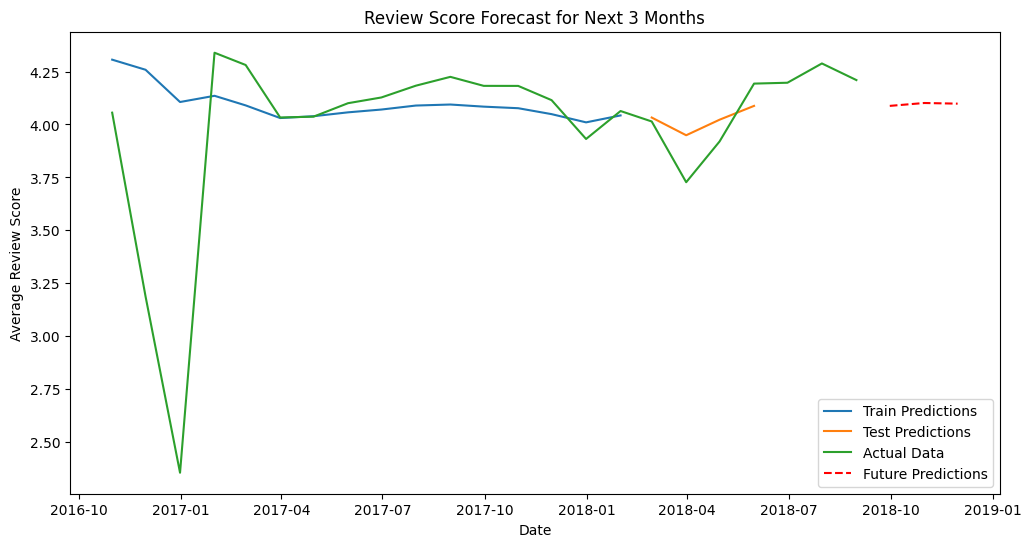

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 1: Prepare time series data
# Read the review_creation_date file and calculate the average monthly review scores
data = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_order_reviews_dataset.csv')
data['review_creation_date'] = pd.to_datetime(data['review_creation_date'])
data.set_index('review_creation_date', inplace=True)

# Calculate the monthly average review score
monthly_avg_score = data['review_score'].resample('M').mean()

# Step 2: Preprocess data for LSTM
# Normalize data for input into the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(monthly_avg_score.values.reshape(-1, 1))

# Split data into input-output sequences
def create_sequences(data, seq_length=3):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 3  # Use the past 3 months to predict the next month
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), verbose=1)

# Step 4: Forecast for the next 2-3 months
# Use the last data sequence from the test set for forecasting
predictions = []
last_sequence = X_test[-1]  # Get the last data sequence

for i in range(3):  # Forecast for the next 3 months
    next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
    predictions.append(next_pred[0, 0])
    # Update the last_sequence for the next month
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

# Print forecast results (after inverse transformation)
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Forecasted review scores for the next 3 months:", predicted_values.flatten())

# Step 5: Visualize the results
# Visualize actual data and predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predicted and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
actual_test_values = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_score.index[:len(train_predictions)], train_predictions, label="Train Predictions")
plt.plot(monthly_avg_score.index[len(train_predictions):len(train_predictions) + len(test_predictions)], test_predictions, label="Test Predictions")
plt.plot(monthly_avg_score.index, monthly_avg_score.values, label="Actual Data")
plt.plot(pd.date_range(start=monthly_avg_score.index[-1], periods=4, freq='M')[1:], predicted_values, label="Future Predictions", linestyle='--', color='red')
plt.title("Review Score Forecast for Next 3 Months")
plt.xlabel("Date")
plt.ylabel("Average Review Score")
plt.legend()
plt.show()


In [ ]:
# Step 1: Convert data to weekly or daily frequency
weekly_avg_score = data['review_score'].resample('W').mean()  # Weekly forecast
# Or use daily_avg_score = data['review_score'].resample('D').mean() for daily forecast

# Normalize the data for LSTM
scaled_data = scaler.fit_transform(weekly_avg_score.values.reshape(-1, 1))

# Create subsequences for LSTM with a smaller sequence length
seq_length = 4  # For example: Use 4 weeks to predict the next week
X, y = create_sequences(scaled_data, seq_length)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Retrain the model
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), verbose=1)

# Short-term forecast for the next 2-3 weeks
predictions = []
last_sequence = X_test[-1]  # Take the last sequence from the test set

for i in range(3):  # Forecast for the next 3 weeks
    next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
    predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

# Print forecast results after inverse transformation
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Forecasted review scores for the next 3 weeks:", predicted_values.flatten())


Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1029 - val_loss: 0.0010
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - val_loss: 0.0024
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0182 - val_loss: 0.0065
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0177 - val_loss: 0.0013
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0205 - val_loss: 0.0027
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0199 - val_loss: 0.0014
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0264 - val_loss: 0.0049
Epoch 9/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0111 - val_loss: 0.0029
Epoch 10/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0220 - val_loss: 0.0025
Epoch 11/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0192 - val_loss: 0.0050
Epoch 12/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

Forecasting for category: esporte_lazer
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4290 - val_loss: 0.0068
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0038
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_lo

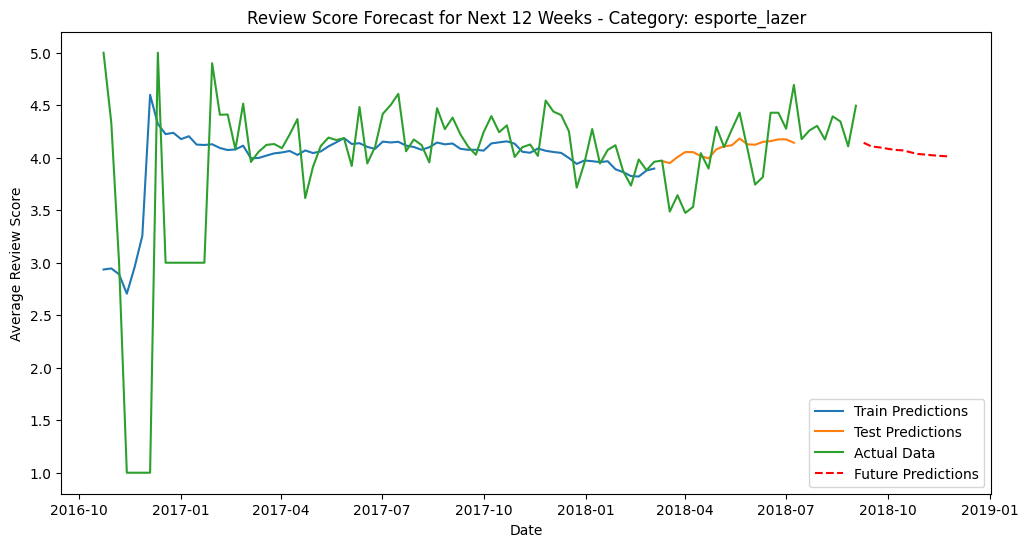

Forecasting for category: informatica_acessorios
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4265 - val_loss: 0.0066
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0031
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0029
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0056
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - val_loss: 0.0045
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0046
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0039
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 0.0085
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0030
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_lo

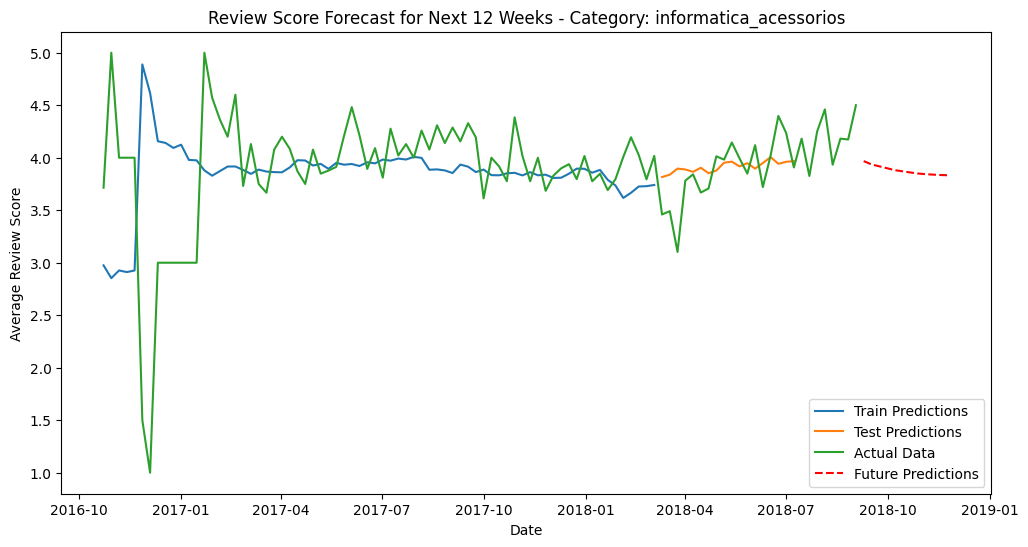

Forecasting for category: ferramentas_jardim
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1753 - val_loss: 0.0232
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0656 - val_loss: 0.0251
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0329 - val_loss: 0.0220
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346 - val_loss: 0.0336
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_loss: 0.0305
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0374 - val_loss: 0.0395
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0482 - val_loss: 0.0253
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0715 - val_loss: 0.0218
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0559 - val_loss: 0.0217
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318 - val_loss: 0.0234
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0404 - val_loss: 0.0220
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0500 - val_l

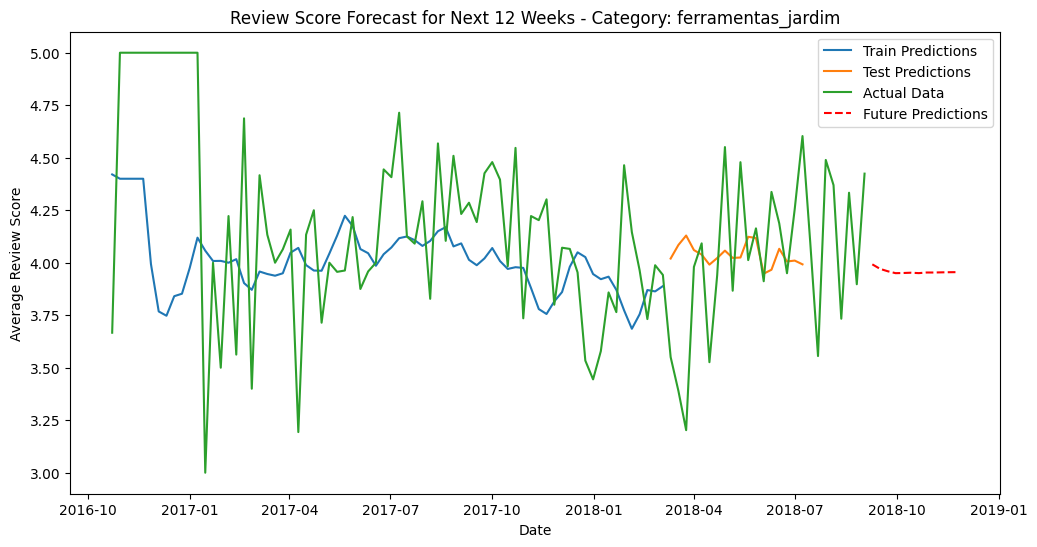

Forecasting for category: cama_mesa_banho
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2439 - val_loss: 0.0065
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0411 - val_loss: 0.0055
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 - val_loss: 0.0084
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322 - val_loss: 0.0029
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348 - val_loss: 0.0016
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0382 - val_loss: 0.0047
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 - val_loss: 0.0027
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - val_loss: 0.0013
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0342 - val_loss: 0.0025
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379 - val_loss: 0.0012
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0062
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0250 - val_lo

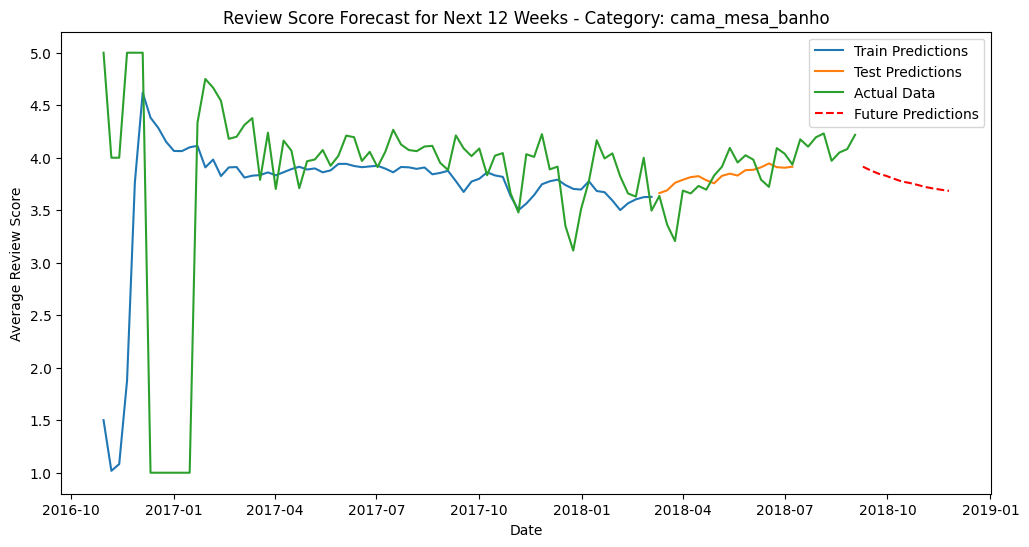

Forecasting for category: brinquedos
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3966 - val_loss: 0.0085
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0313 - val_loss: 0.0038
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - val_loss: 0.0095
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0533 - val_loss: 0.0063
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - val_loss: 0.0253
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0355 - val_loss: 0.0062
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397 - val_loss: 0.0079
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 - val_loss: 0.0034
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0621 - val_loss: 0.0035
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 - val_loss: 0.0046
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - val_loss: 0.0104
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_lo

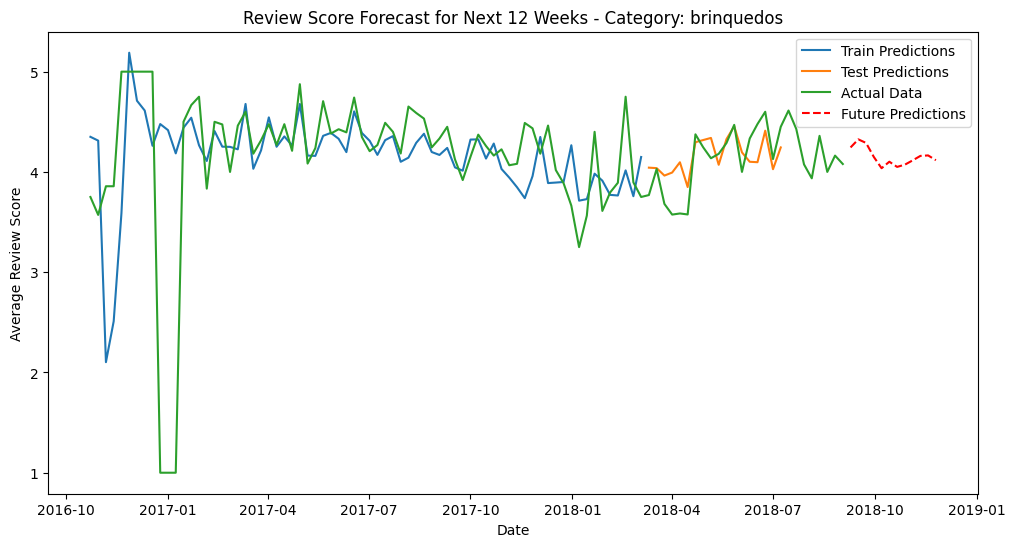

Forecasting for category: casa_conforto
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.3323 - val_loss: 0.0349
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0648 - val_loss: 0.0396
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0737 - val_loss: 0.0307
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0695 - val_loss: 0.0322
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503 - val_loss: 0.0561
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0602 - val_loss: 0.0316
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421 - val_loss: 0.0371
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0428 - val_loss: 0.0637
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - val_loss: 0.0300
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0363 - val_loss: 0.0490
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0512 - val_loss: 0.0441
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0417 - val_l

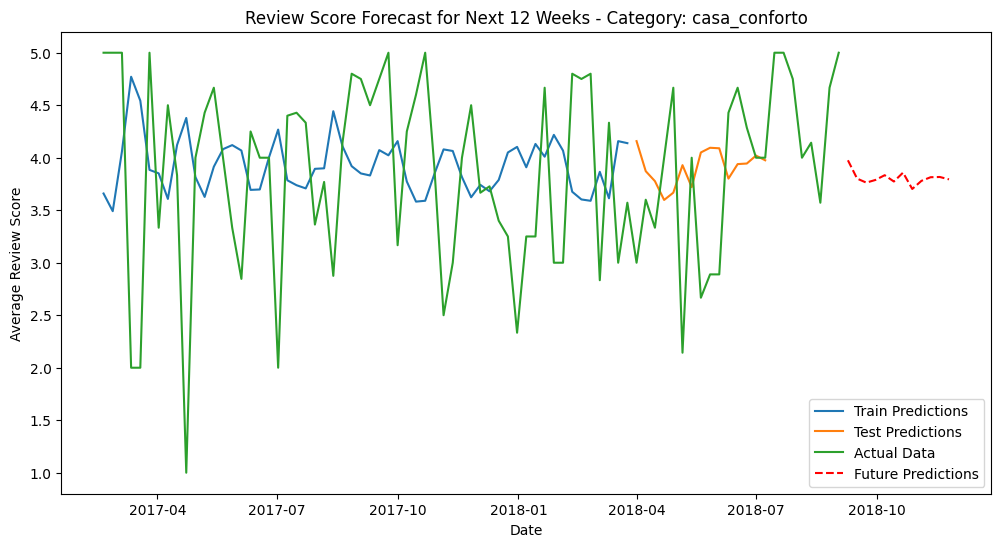

Forecasting for category: eletroportateis
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3625 - val_loss: 0.0324
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341 - val_loss: 0.0290
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.0347
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0394 - val_loss: 0.0287
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0374 - val_loss: 0.0288
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 - val_loss: 0.0289
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0354 - val_loss: 0.0310
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0445 - val_loss: 0.0300
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454 - val_loss: 0.0287
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - val_loss: 0.0306
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305 - val_loss: 0.0328
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_lo

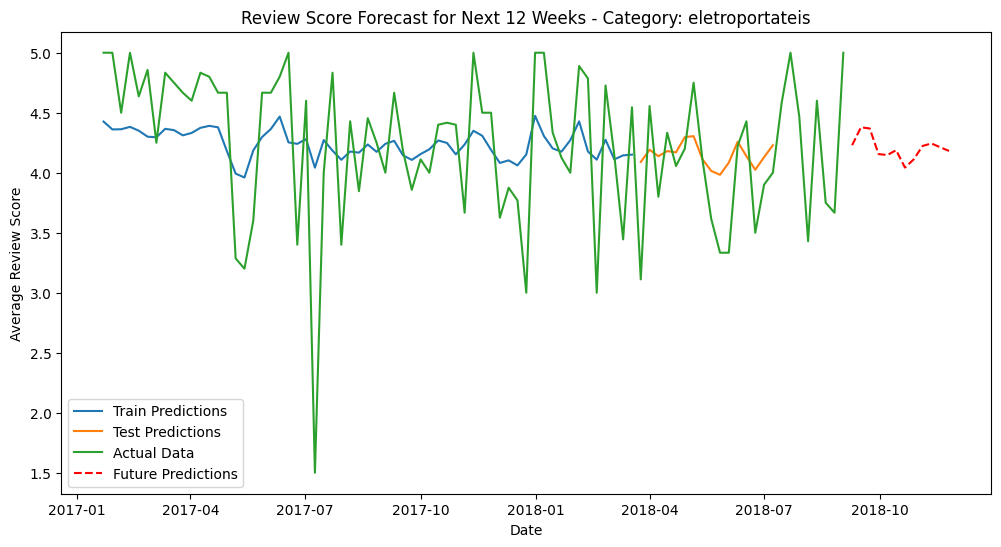

Forecasting for category: beleza_saude
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2818 - val_loss: 0.0076
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - val_loss: 0.0042
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - val_loss: 0.0097
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349 - val_loss: 0.0060
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0247 - val_loss: 0.0060
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0356 - val_loss: 0.0060
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0266 - val_loss: 0.0043
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0269 - val_loss: 0.0068
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.0062
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - val_loss: 0.0060
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_lo

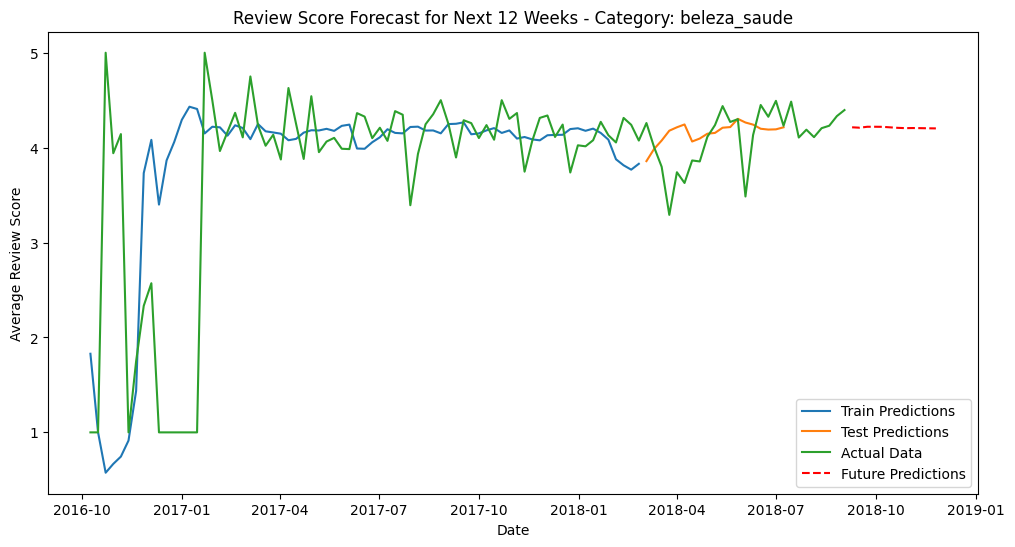

Forecasting for category: pet_shop
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1984 - val_loss: 0.0346
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 - val_loss: 0.0328
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0601 - val_loss: 0.0270
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 - val_loss: 0.0245
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0381 - val_loss: 0.0193
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - val_loss: 0.0278
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0368 - val_loss: 0.0183
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346 - val_loss: 0.0215
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - val_loss: 0.0208
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0534 - val_loss: 0.0236
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.0202
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 - val_lo

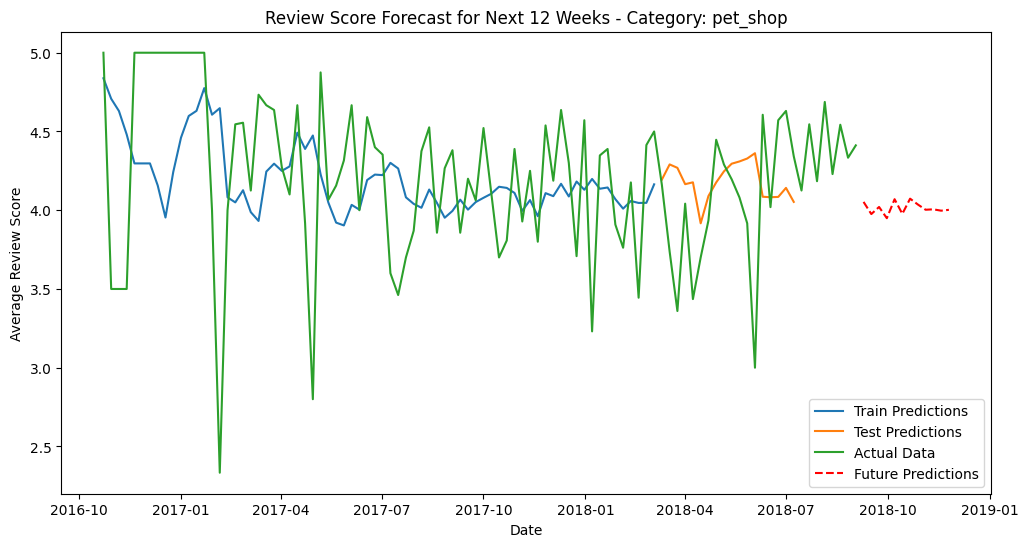

Forecasting for category: cool_stuff
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2546 - val_loss: 0.0135
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.0222
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0409 - val_loss: 0.0095
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0317 - val_loss: 0.0067
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288 - val_loss: 0.0091
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321 - val_loss: 0.0090
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.0097
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0377 - val_loss: 0.0089
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 - val_loss: 0.0079
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 - val_loss: 0.0140
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.0074
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_lo

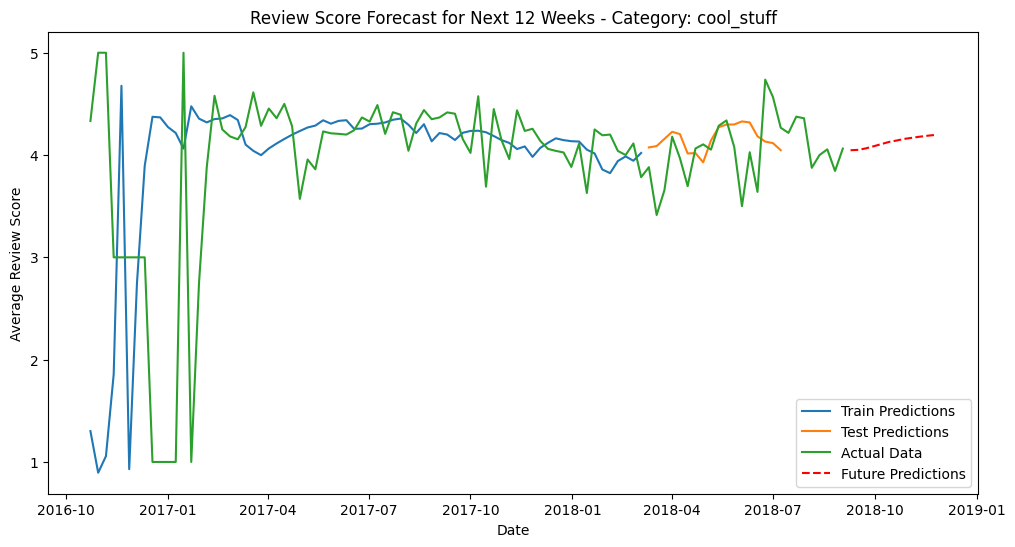

Forecasting for category: eletronicos
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1870 - val_loss: 0.0036
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0852 - val_loss: 0.0073
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0758 - val_loss: 0.0030
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0715 - val_loss: 0.0030
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0429 - val_loss: 0.0070
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0728 - val_loss: 0.0030
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0382 - val_loss: 0.0093
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0374 - val_loss: 0.0067
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - val_loss: 0.0038
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361 - val_loss: 0.0023
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325 - val_loss: 0.0020
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0368 - val_lo

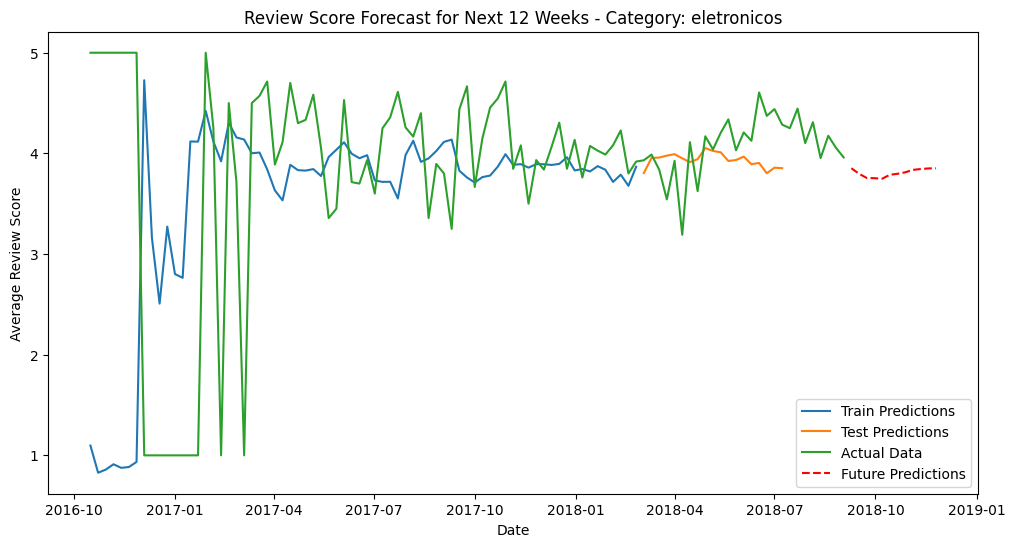

Forecasting for category: bebes
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3634 - val_loss: 0.0051
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549 - val_loss: 0.0044
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0622 - val_loss: 0.0032
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467 - val_loss: 0.0031
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0464 - val_loss: 0.0058
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0329 - val_loss: 0.0079
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438 - val_loss: 0.0060
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - val_loss: 0.0146
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - val_loss: 0.0291
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.0034
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.0088
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - val_lo

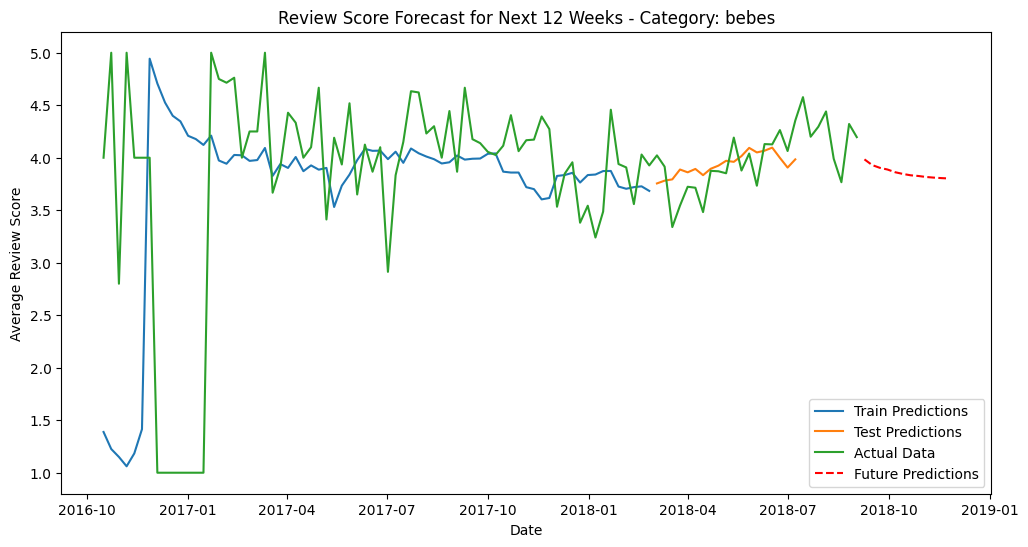

Forecasting for category: malas_acessorios
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3200 - val_loss: 0.0359
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0415 - val_loss: 0.0353
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0353 - val_loss: 0.0386
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - val_loss: 0.0342
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - val_loss: 0.0358
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0398 - val_loss: 0.0366
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334 - val_loss: 0.0322
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330 - val_loss: 0.0298
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524 - val_loss: 0.0300
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0579 - val_loss: 0.0296
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0382 - val_loss: 0.0300
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - val_l

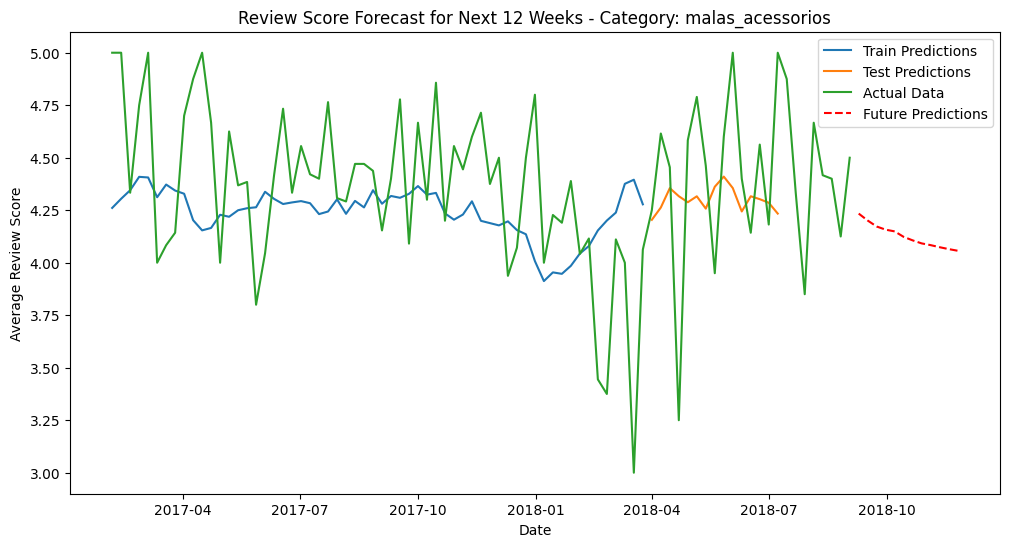

Forecasting for category: utilidades_domesticas
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2429 - val_loss: 0.0056
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0324 - val_loss: 0.0027
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343 - val_loss: 0.0025
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.0028
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - val_loss: 0.0023
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - val_loss: 0.0044
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0025
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - val_loss: 0.0024
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0191 - val_loss: 0.0024
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0185 - val_loss: 0.0025
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - val_loss: 0.0023
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - val_lo

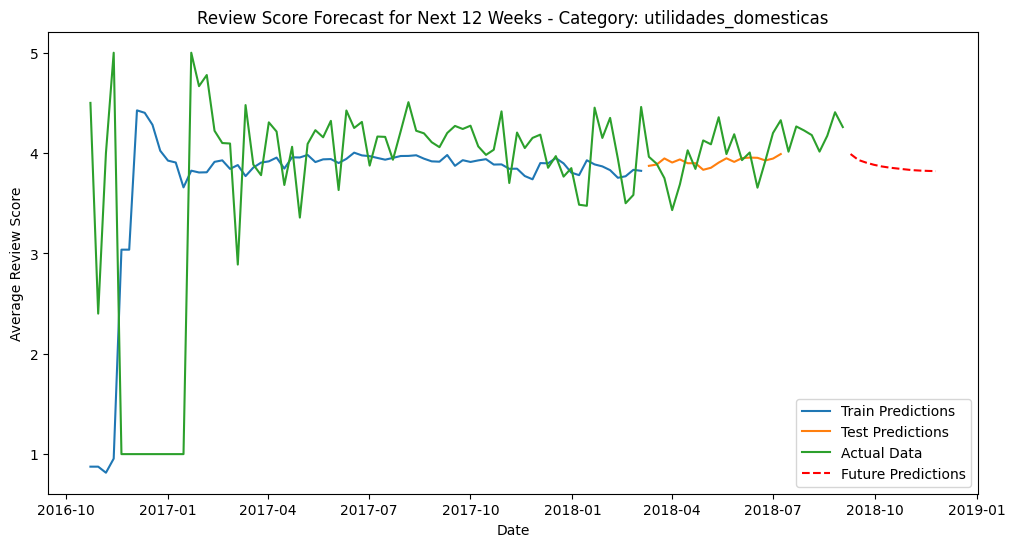

Forecasting for category: relogios_presentes
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3597 - val_loss: 0.0136
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375 - val_loss: 0.0079
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0435 - val_loss: 0.0043
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 - val_loss: 0.0037
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0537 - val_loss: 0.0035
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0440 - val_loss: 0.0039
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0062
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0636 - val_loss: 0.0032
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - val_loss: 0.0082
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0445 - val_loss: 0.0096
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333 - val_loss: 0.0083
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_lo

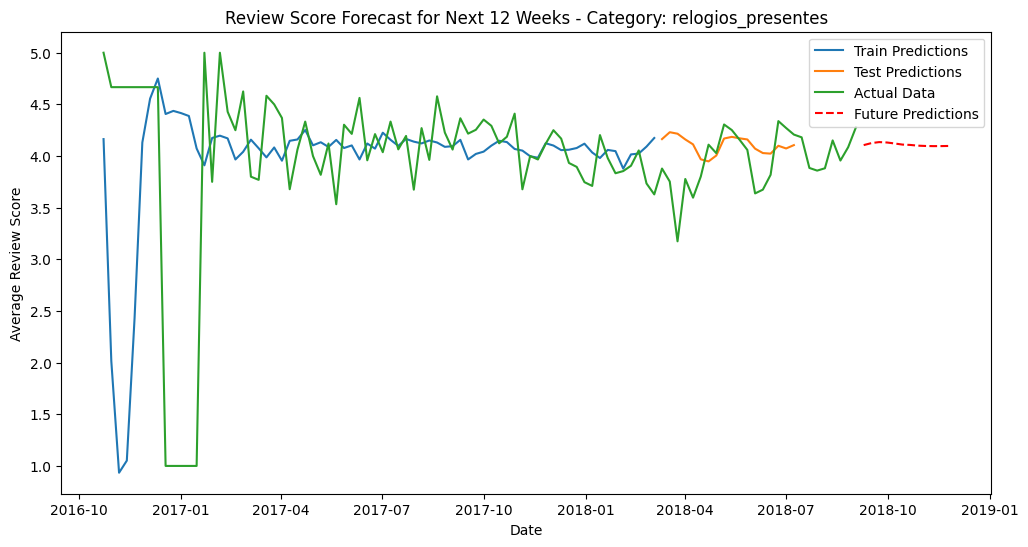

Forecasting for category: automotivo
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3896 - val_loss: 0.0058
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.0030
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0030
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0026
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0060
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0027
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0027
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0031
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - val_loss: 0.0025
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 - val_loss: 0.0039
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_lo

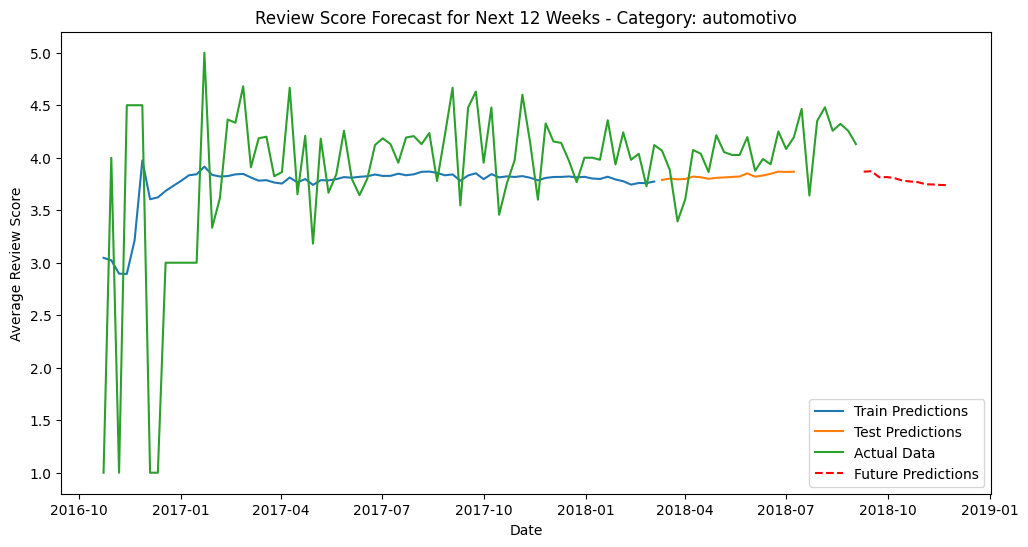

Forecasting for category: telefonia
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2388 - val_loss: 0.0156
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0204 - val_loss: 0.0097
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0382 - val_loss: 0.0045
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0537 - val_loss: 0.0047
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - val_loss: 0.0052
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0100
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0409 - val_loss: 0.0047
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0369 - val_loss: 0.0048
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0527 - val_loss: 0.0045
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - val_loss: 0.0083
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0309 - val_loss: 0.0059
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 - val_l

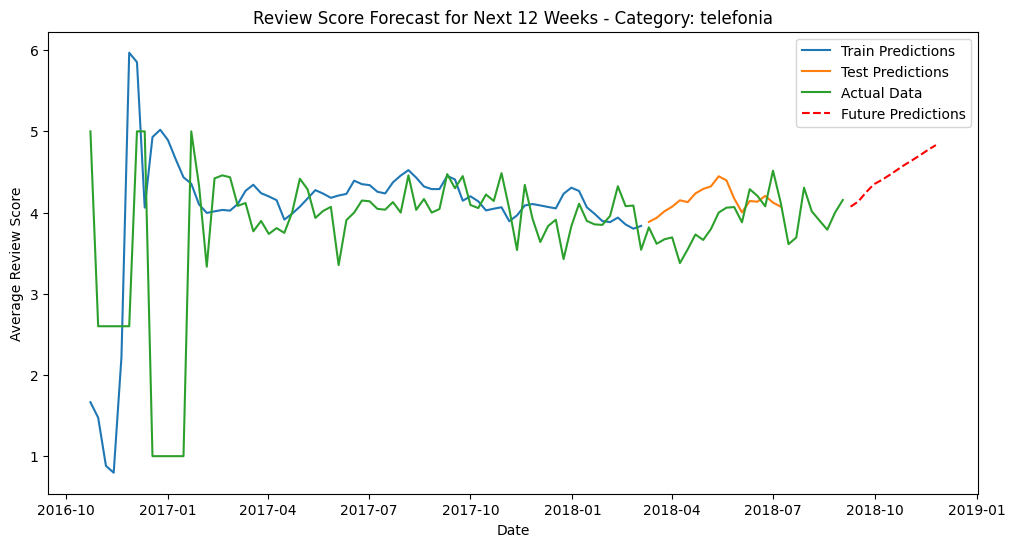

Forecasting for category: fashion_bolsas_e_acessorios
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2054 - val_loss: 0.0115
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0473 - val_loss: 0.0116
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0402 - val_loss: 0.0109
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0405 - val_loss: 0.0105
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0359 - val_loss: 0.0101
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331 - val_loss: 0.0118
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0333 - val_loss: 0.0146
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0297 - val_loss: 0.0114
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0389 - val_loss: 0.0161
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0355 - val_loss: 0.0131
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0437 - val_loss: 0.0113
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0355 - val_lo

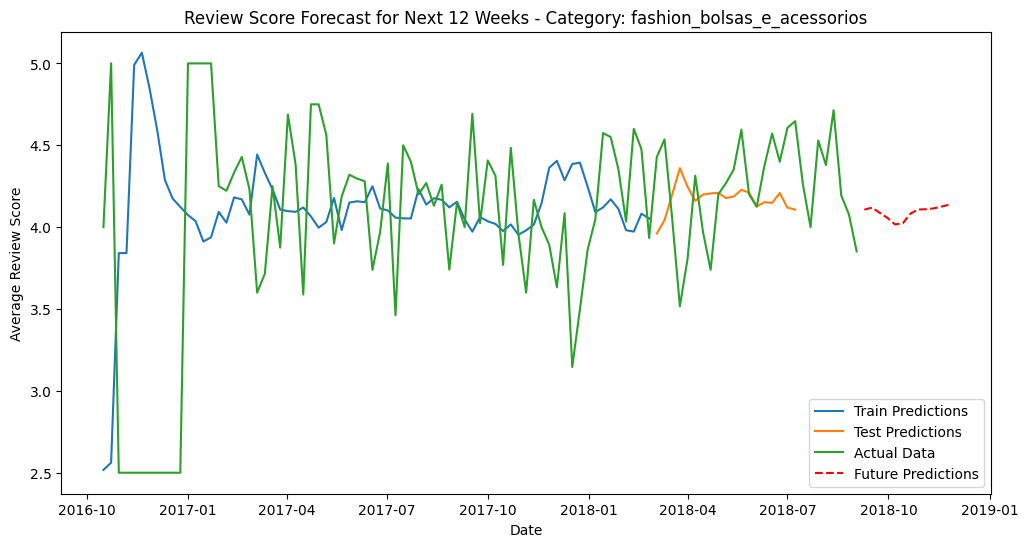

Forecasting for category: perfumaria
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3200 - val_loss: 0.0065
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.0083
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0060
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0089
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0075
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0112
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0086
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_lo

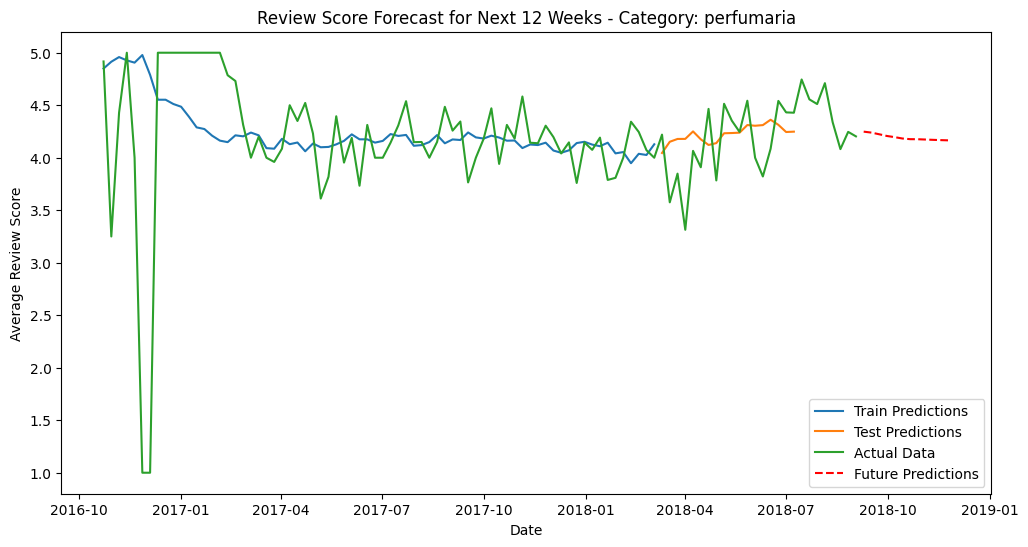

Forecasting for category: moveis_decoracao
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2155 - val_loss: 0.0168
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278 - val_loss: 0.0041
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.0048
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0531 - val_loss: 0.0046
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - val_loss: 0.0075
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - val_loss: 0.0071
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - val_loss: 0.0048
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0322 - val_loss: 0.0037
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195 - val_loss: 0.0048
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157 - val_loss: 0.0207
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - val_loss: 0.0130
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - val_lo

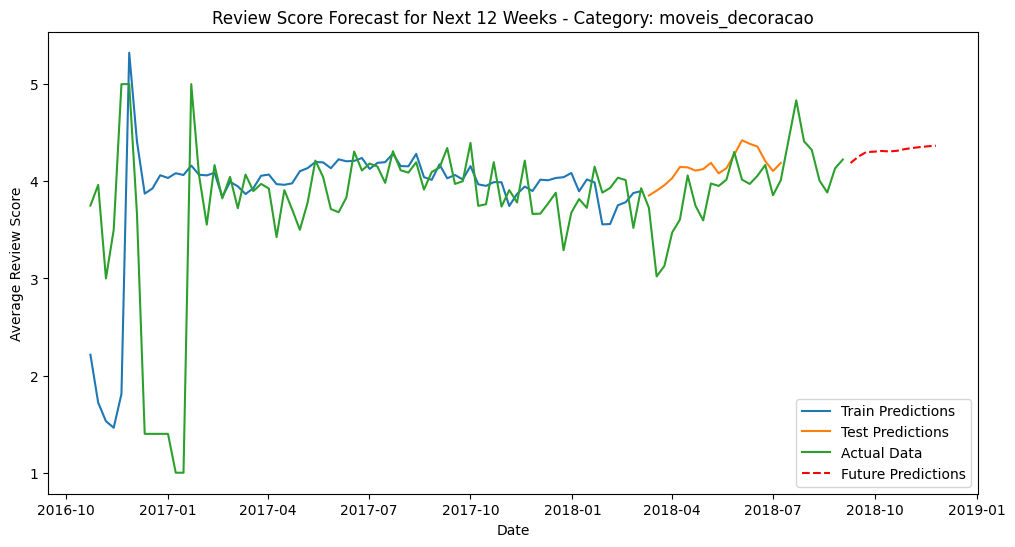

Forecasting for category: eletrodomesticos_2
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2530 - val_loss: 0.0150
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0402 - val_loss: 0.0186
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0572 - val_loss: 0.0151
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486 - val_loss: 0.0197
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0656 - val_loss: 0.0155
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558 - val_loss: 0.0159
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0841 - val_loss: 0.0157
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0648 - val_loss: 0.0151
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469 - val_loss: 0.0234
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0611 - val_loss: 0.0195
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0404 - val_loss: 0.0204
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - val_l

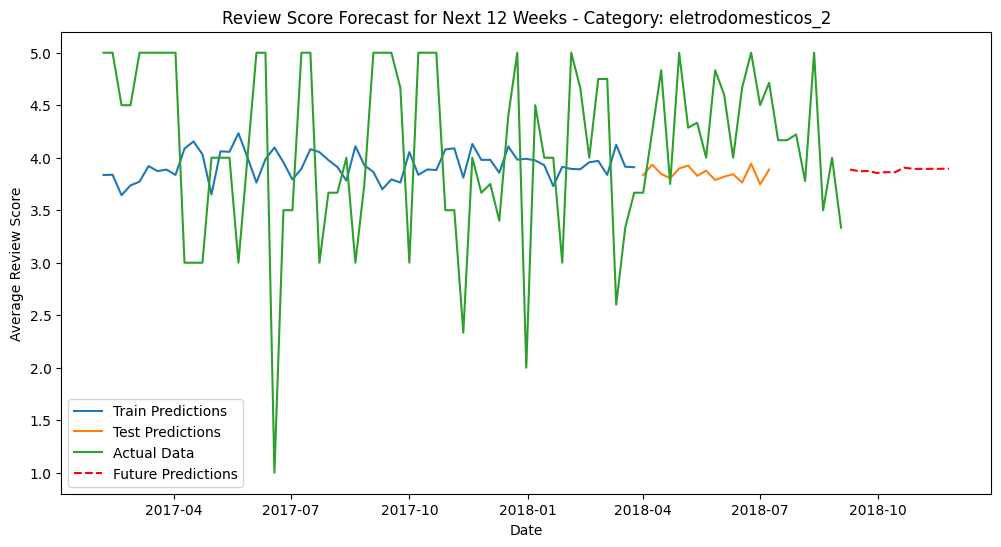

Forecasting for category: alimentos_bebidas
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6263 - val_loss: 0.0564
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415 - val_loss: 0.0366
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406 - val_loss: 0.0455
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0442 - val_loss: 0.0376
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0602 - val_loss: 0.0365
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.0562
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0641 - val_loss: 0.0369
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443 - val_loss: 0.0367
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415 - val_loss: 0.0360
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - val_loss: 0.0370
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0903 - val_loss: 0.0352
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0577 - val_l

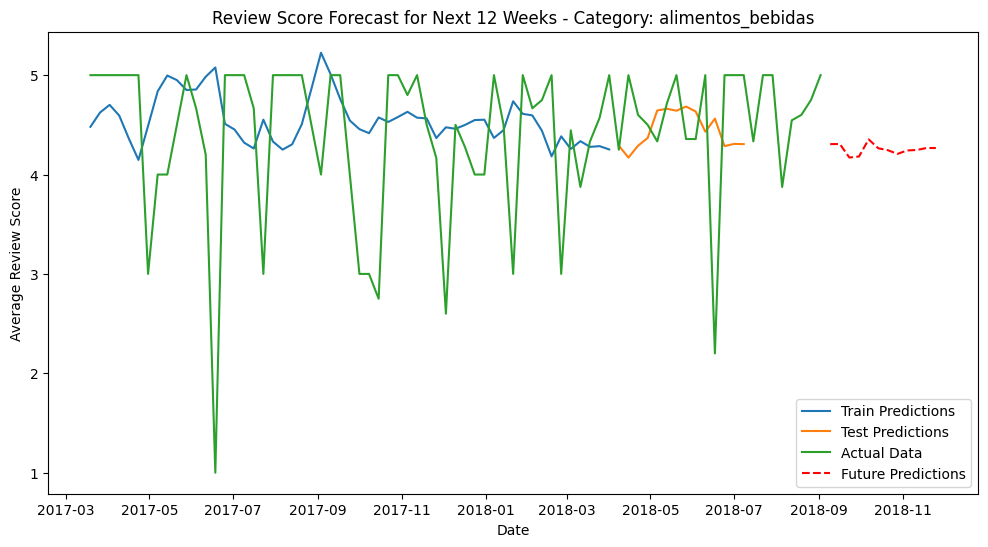

Forecasting for category: instrumentos_musicais
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3578 - val_loss: 0.0092
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0480 - val_loss: 0.0090
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0285 - val_loss: 0.0126
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0332 - val_loss: 0.0088
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0301 - val_loss: 0.0102
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0448 - val_loss: 0.0184
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0362 - val_loss: 0.0086
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0385 - val_loss: 0.0127
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0293 - val_loss: 0.0126
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322 - val_loss: 0.0151
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.0085
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280 - val_l

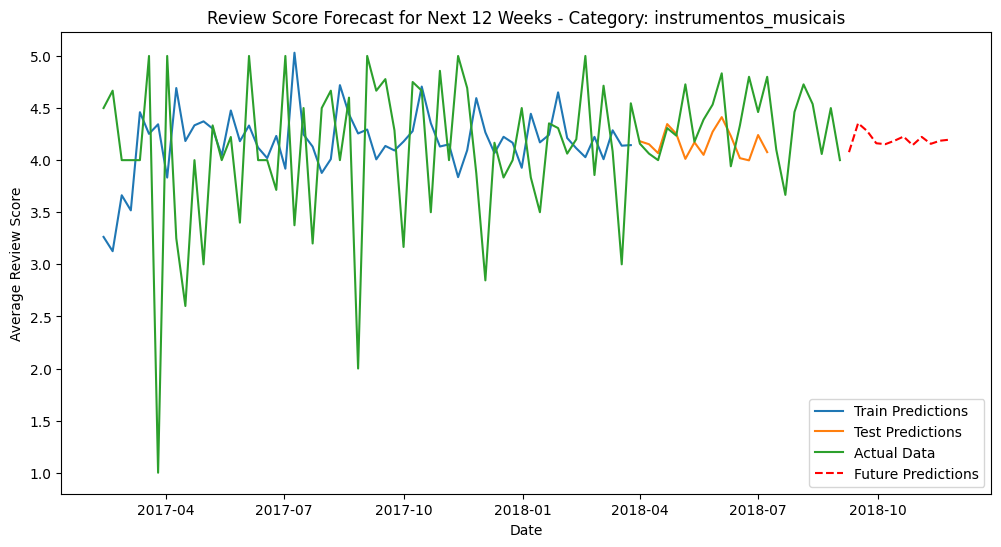

Forecasting for category: papelaria
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2304 - val_loss: 0.0129
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0479 - val_loss: 0.0597
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0544 - val_loss: 0.0185
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0566 - val_loss: 0.0149
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0463 - val_loss: 0.0405
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0689 - val_loss: 0.0194
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0679 - val_loss: 0.0207
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0691 - val_loss: 0.0149
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443 - val_loss: 0.0119
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0559 - val_loss: 0.0149
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0531 - val_loss: 0.0193
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390 - val_l

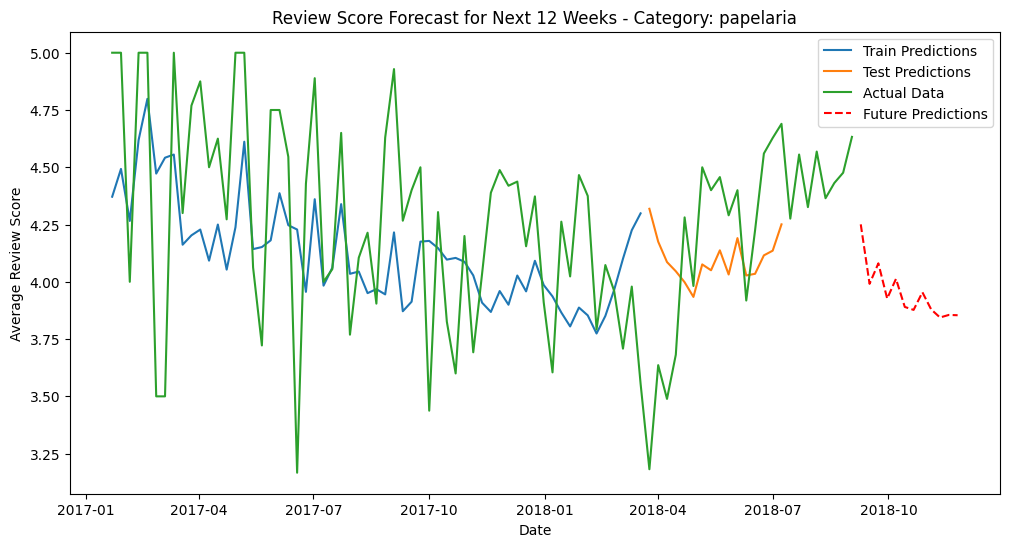

Forecasting for category: livros_importados
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3960 - val_loss: 0.1268
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0591 - val_loss: 0.1347
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0539 - val_loss: 0.1301
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0869 - val_loss: 0.1318
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455 - val_loss: 0.1338
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0600 - val_loss: 0.1208
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0628 - val_loss: 0.1406
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0328 - val_loss: 0.1259
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 - val_loss: 0.1438
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0583 - val_loss: 0.1172
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0520 - val_loss: 0.1210
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0639 - val_l

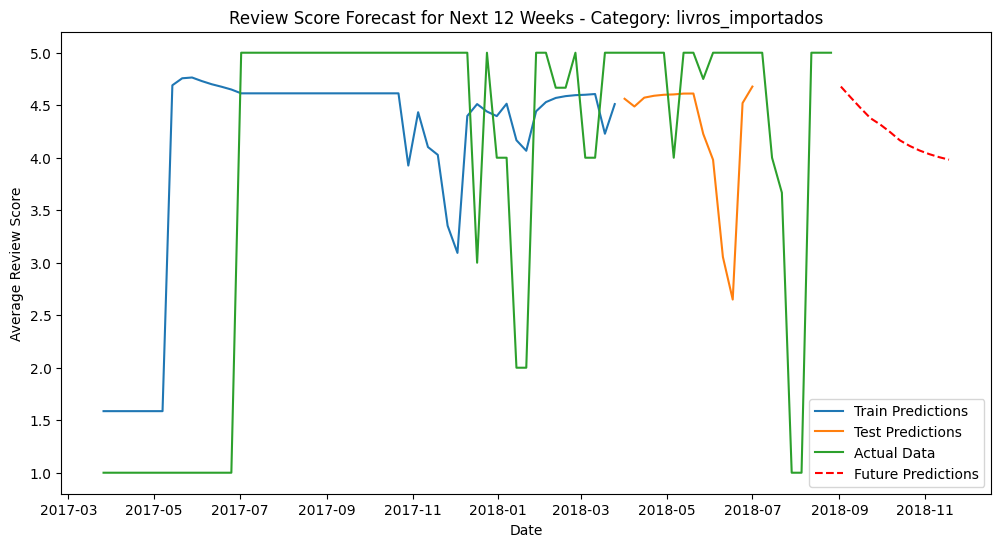

Forecasting for category: moveis_escritorio
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2723 - val_loss: 0.0224
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - val_loss: 0.0162
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0321 - val_loss: 0.0200
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0272 - val_loss: 0.0169
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295 - val_loss: 0.0182
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288 - val_loss: 0.0164
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.0198
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230 - val_loss: 0.0204
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0258 - val_loss: 0.0163
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0262 - val_loss: 0.0175
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - val_loss: 0.0158
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0334 - val_l

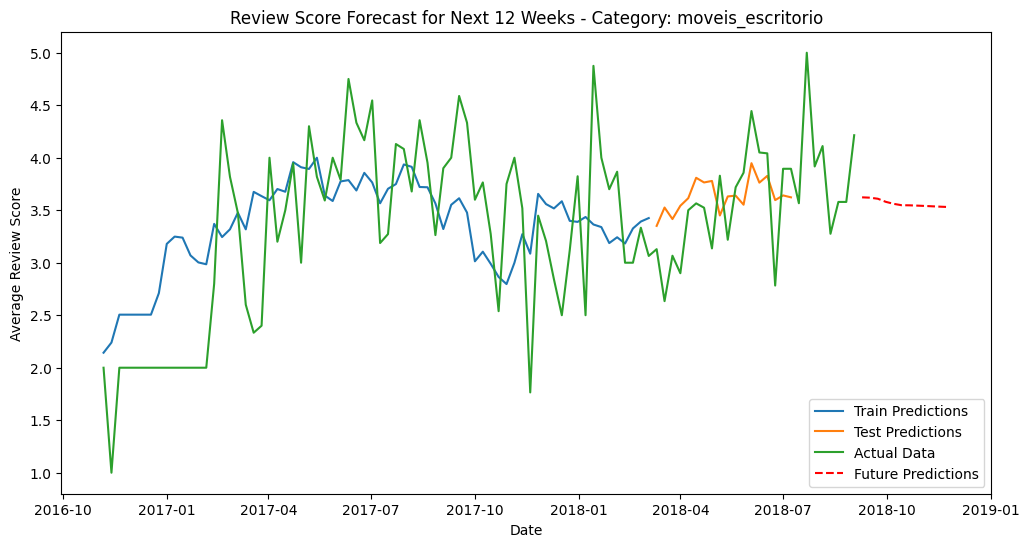

Forecasting for category: livros_interesse_geral
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2608 - val_loss: 0.0309
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0738 - val_loss: 0.0443
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0643 - val_loss: 0.0304
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0572 - val_loss: 0.0357
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0893 - val_loss: 0.0357
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0721 - val_loss: 0.0370
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0772 - val_loss: 0.0299
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0601 - val_loss: 0.0306
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0671 - val_loss: 0.0302
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0555 - val_loss: 0.0346
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0616 - val_loss: 0.0323
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0442 - val_lo

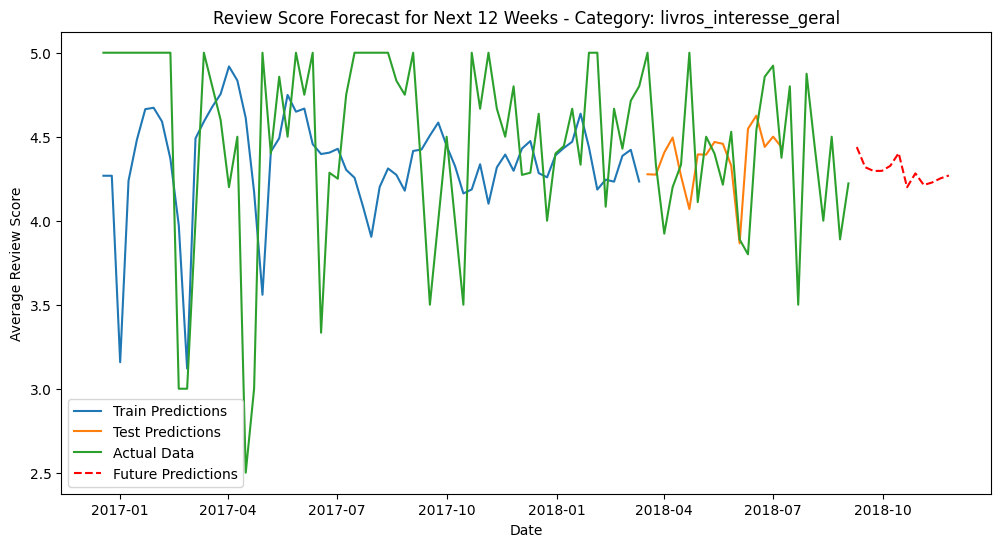

Forecasting for category: construcao_ferramentas_construcao
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3322 - val_loss: 0.0078
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 - val_loss: 0.0284
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0696 - val_loss: 0.0038
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0600 - val_loss: 0.0041
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0527 - val_loss: 0.0085
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0722 - val_loss: 0.0086
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0378 - val_loss: 0.0164
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299 - val_loss: 0.0048
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449 - val_loss: 0.0041
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422 - val_loss: 0.0040
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0044
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_lo

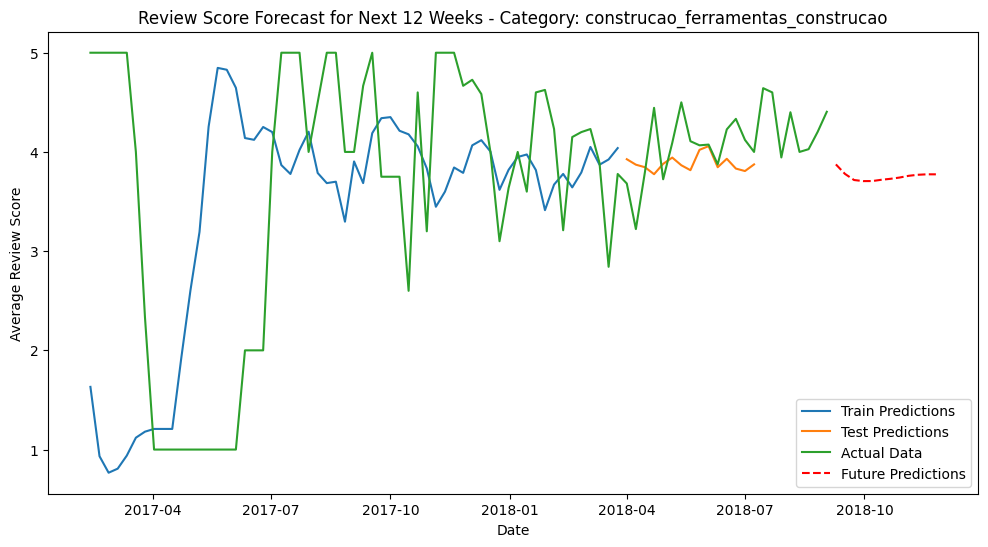

Forecasting for category: livros_tecnicos
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4341 - val_loss: 0.0260
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0476 - val_loss: 0.0127
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443 - val_loss: 0.0170
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0415 - val_loss: 0.0116
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307 - val_loss: 0.0139
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0512 - val_loss: 0.0151
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - val_loss: 0.0111
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 - val_loss: 0.0115
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0434 - val_loss: 0.0108
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - val_loss: 0.0126
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0357 - val_loss: 0.0129
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0292 - val_lo

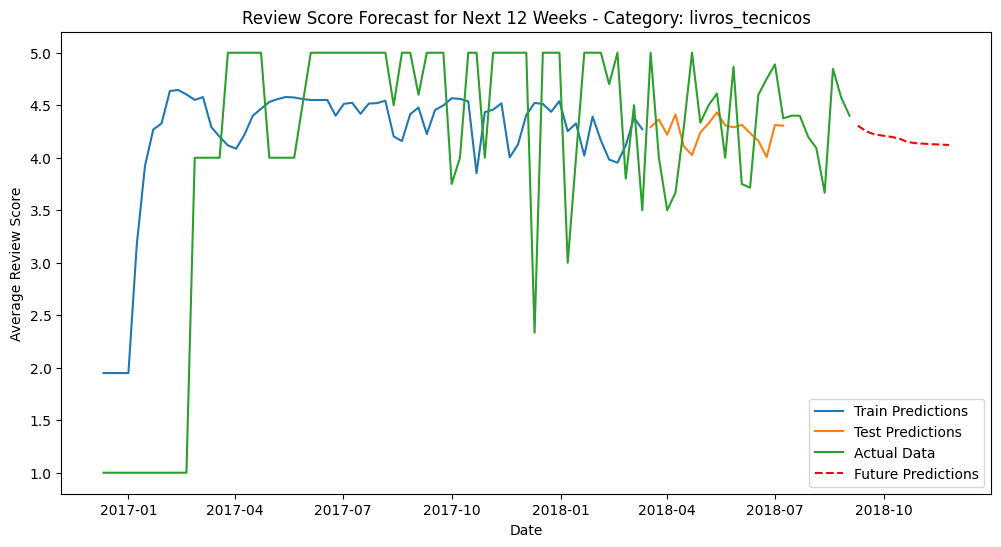

Forecasting for category: construcao_ferramentas_seguranca
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3101 - val_loss: 0.0454
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0678 - val_loss: 0.0666
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0814 - val_loss: 0.0459
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0673 - val_loss: 0.0437
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0431 - val_loss: 0.0406
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0896 - val_loss: 0.0372
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0682 - val_loss: 0.0408
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437 - val_loss: 0.0368
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0751 - val_loss: 0.0454
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0602 - val_loss: 0.0393
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0526 - val_loss: 0.0387
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0707 - val_l

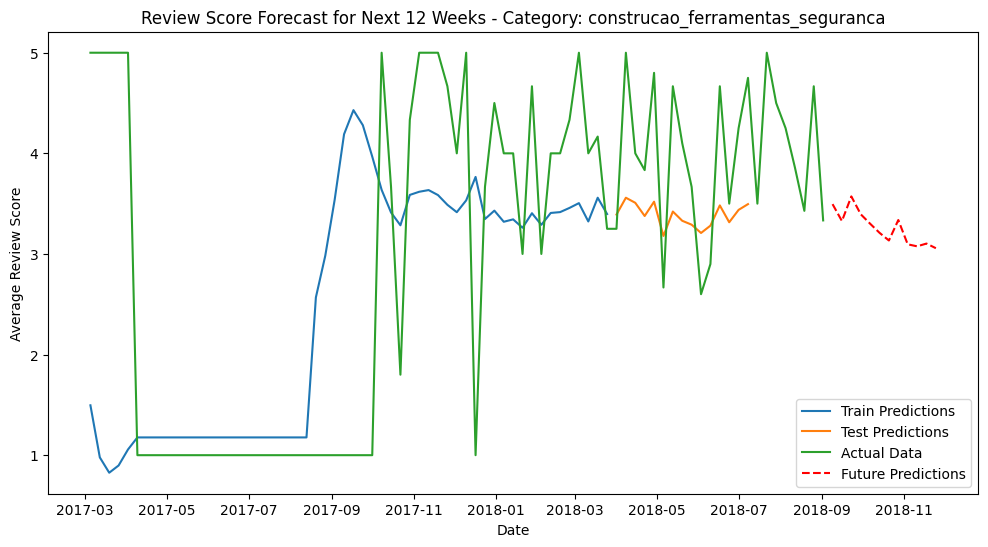

Forecasting for category: artes
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4140 - val_loss: 0.0556
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0580 - val_loss: 0.0560
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0834 - val_loss: 0.0581
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0947 - val_loss: 0.0558
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0623 - val_loss: 0.0565
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0968 - val_loss: 0.0732
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0578 - val_loss: 0.0700
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0861 - val_loss: 0.0696
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0769 - val_loss: 0.0568
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0741 - val_loss: 0.0585
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0434 - val_loss: 0.0584
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0978 - val_lo

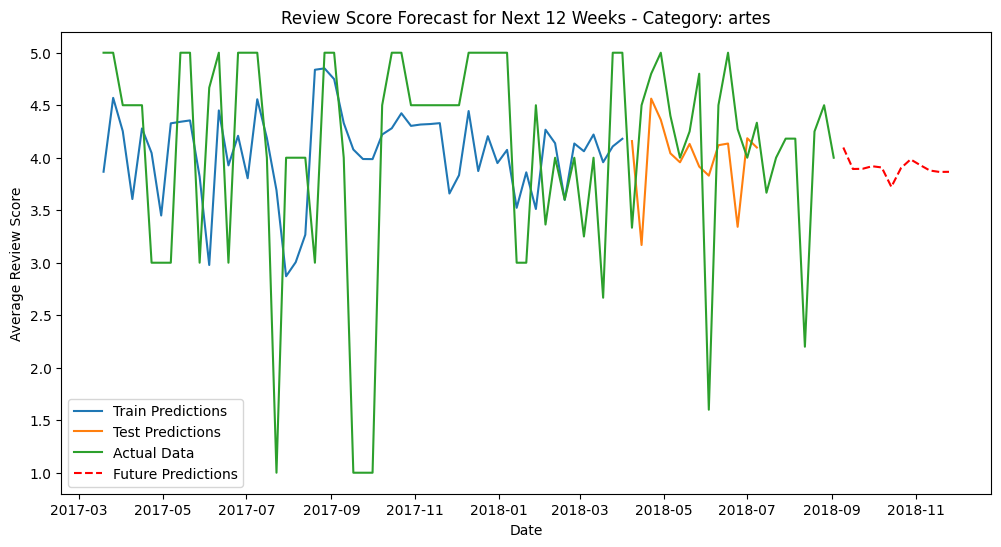

Forecasting for category: eletrodomesticos
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2244 - val_loss: 0.0167
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0537 - val_loss: 0.0127
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0456 - val_loss: 0.0197
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0488 - val_loss: 0.0079
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315 - val_loss: 0.0095
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422 - val_loss: 0.0077
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429 - val_loss: 0.0091
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317 - val_loss: 0.0238
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561 - val_loss: 0.0096
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0498 - val_loss: 0.0076
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0664 - val_loss: 0.0081
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295 - val_lo

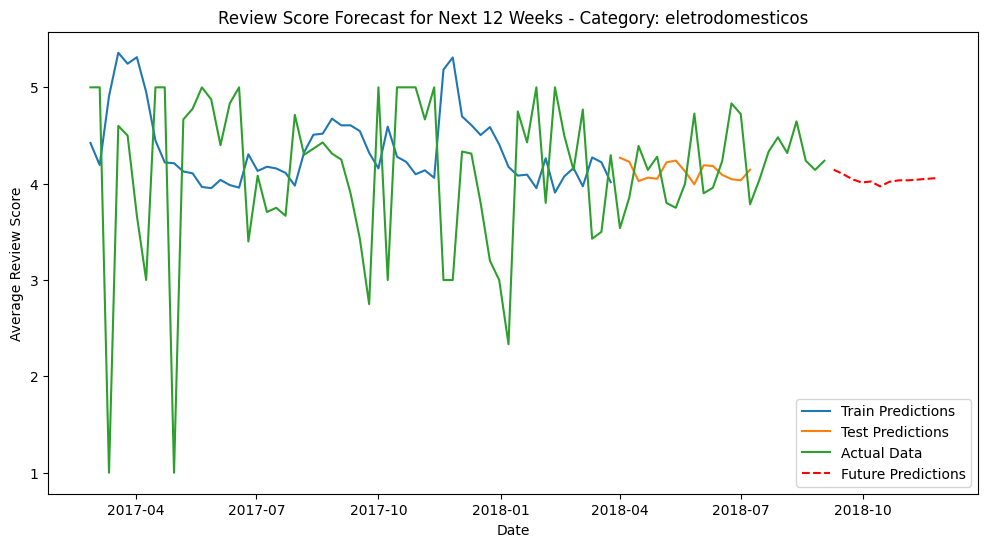

Forecasting for category: pcs
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3947 - val_loss: 0.0837
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0777 - val_loss: 0.0811
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0571 - val_loss: 0.0793
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0483 - val_loss: 0.0796
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0385 - val_loss: 0.0823
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0500 - val_loss: 0.0918
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0753 - val_loss: 0.0847
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0364 - val_loss: 0.0867
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0697 - val_loss: 0.0879
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.0875
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0248 - val_loss: 0.0960
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0392 - val_lo

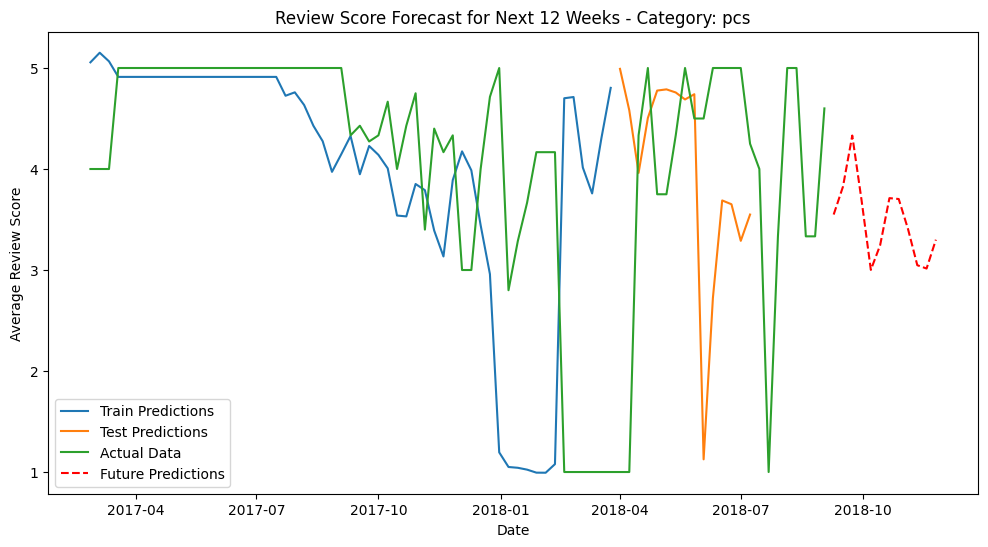

Forecasting for category: artigos_de_natal
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.4736 - val_loss: 0.0417
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1259 - val_loss: 0.0312
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0849 - val_loss: 0.0322
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1003 - val_loss: 0.0467
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0907 - val_loss: 0.0295
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0572 - val_loss: 0.0294
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1002 - val_loss: 0.0294
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0802 - val_loss: 0.0447
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0979 - val_loss: 0.0296
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0920 - val_loss: 0.0319
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0833 - val_loss: 0.0341
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0372 - val_l

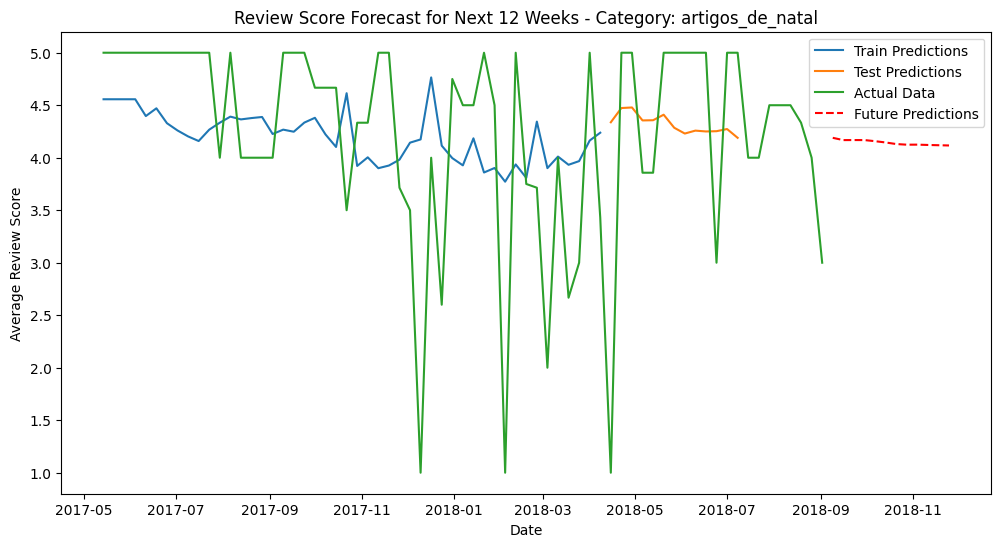

Forecasting for category: audio
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3861 - val_loss: 0.0418
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0633 - val_loss: 0.0454
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0613 - val_loss: 0.0724
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0676 - val_loss: 0.0405
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0666 - val_loss: 0.0516
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0534 - val_loss: 0.0934
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0708 - val_loss: 0.0461
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0868 - val_loss: 0.0472
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0591 - val_loss: 0.0633
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0585 - val_loss: 0.0437
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1348 - val_loss: 0.0404
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0590 - val_lo

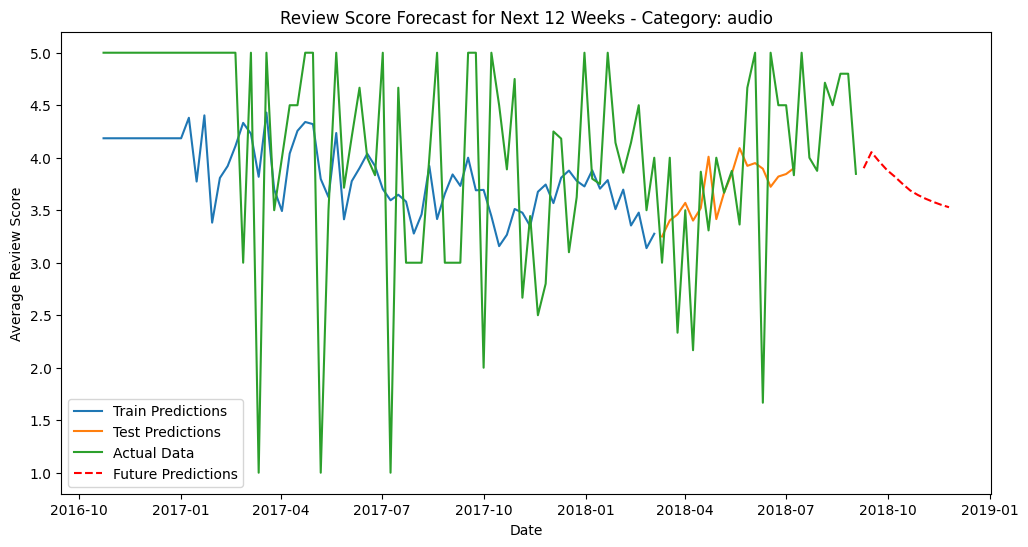

Forecasting for category: nan
Category 'nan' does not have enough data for forecasting.
Forecasting for category: industria_comercio_e_negocios
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.5233 - val_loss: 0.0327
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0384 - val_loss: 0.0280
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0343 - val_loss: 0.0284
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0367 - val_loss: 0.0279
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393 - val_loss: 0.0352
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0371 - val_loss: 0.0280
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0335 - val_loss: 0.0427
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0308 - val_loss: 0.0344
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285 - val_loss: 0.0275
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0508 - val_loss: 0.0290
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0890 - val_loss: 0.0276
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0410 - val_l

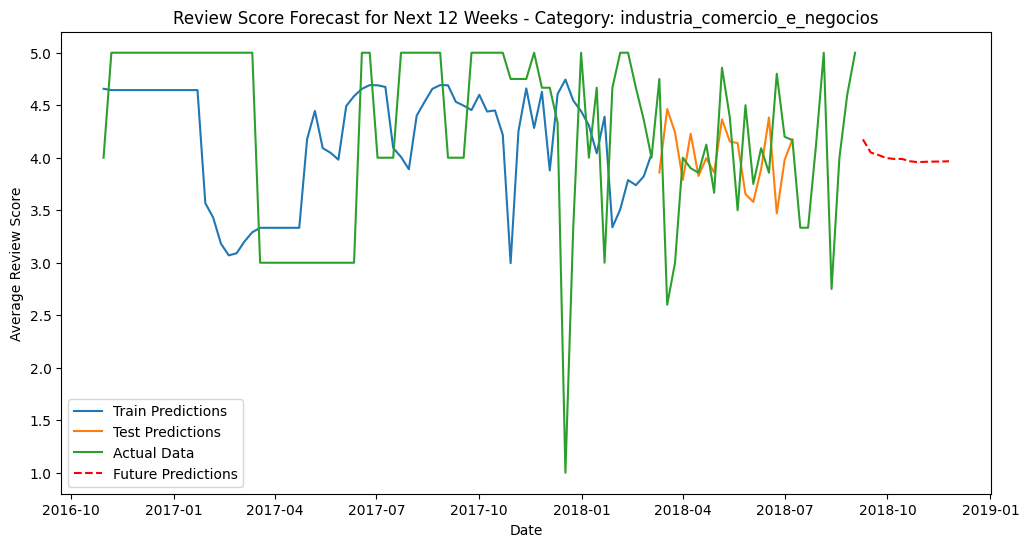

Forecasting for category: moveis_sala
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4012 - val_loss: 0.0442
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0523 - val_loss: 0.0519
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0548 - val_loss: 0.0428
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0509 - val_loss: 0.0699
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0857 - val_loss: 0.0395
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0581 - val_loss: 0.0514
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0644 - val_loss: 0.0383
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0638 - val_loss: 0.0395
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0718 - val_loss: 0.0391
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0627 - val_loss: 0.0473
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0623 - val_loss: 0.0406
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0477 - val_l

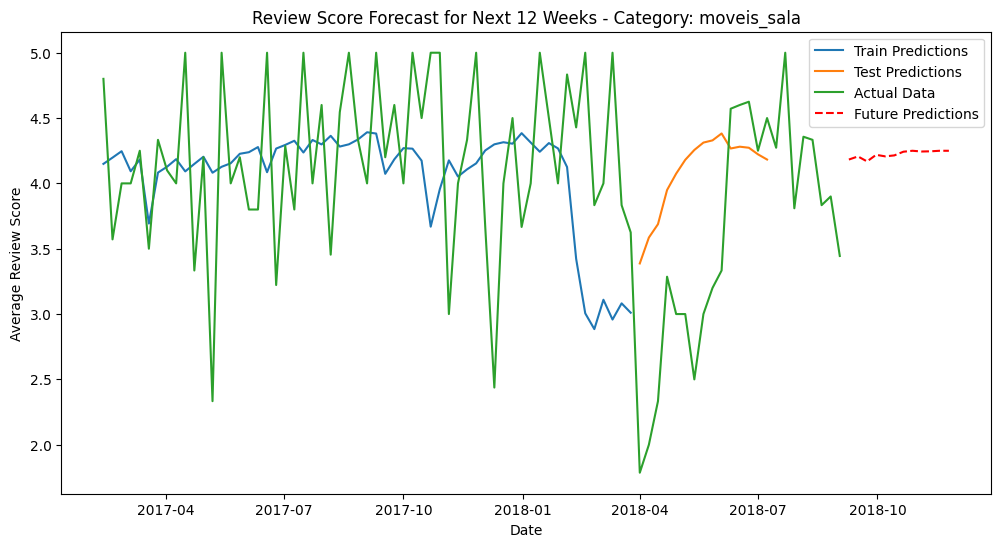

Forecasting for category: consoles_games
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2546 - val_loss: 0.0341
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285 - val_loss: 0.0308
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0403 - val_loss: 0.0361
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0375 - val_loss: 0.0318
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0268 - val_loss: 0.0317
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220 - val_loss: 0.0304
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363 - val_loss: 0.0322
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - val_loss: 0.0306
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0350 - val_loss: 0.0310
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0227 - val_loss: 0.0340
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0181 - val_loss: 0.0336
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_l

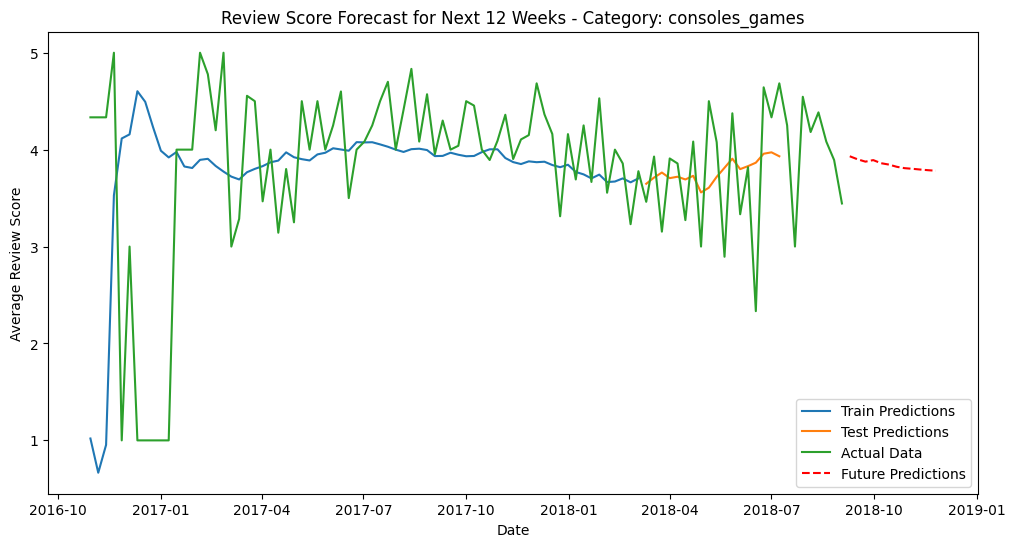

Forecasting for category: market_place
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4429 - val_loss: 0.0862
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0556 - val_loss: 0.0857
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0778 - val_loss: 0.0824
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0682 - val_loss: 0.0820
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0784 - val_loss: 0.0833
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0757 - val_loss: 0.0806
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0589 - val_loss: 0.0838
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0540 - val_loss: 0.0840
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0825 - val_loss: 0.0823
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0542 - val_loss: 0.1058
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0746 - val_loss: 0.0900
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0445 - val_lo

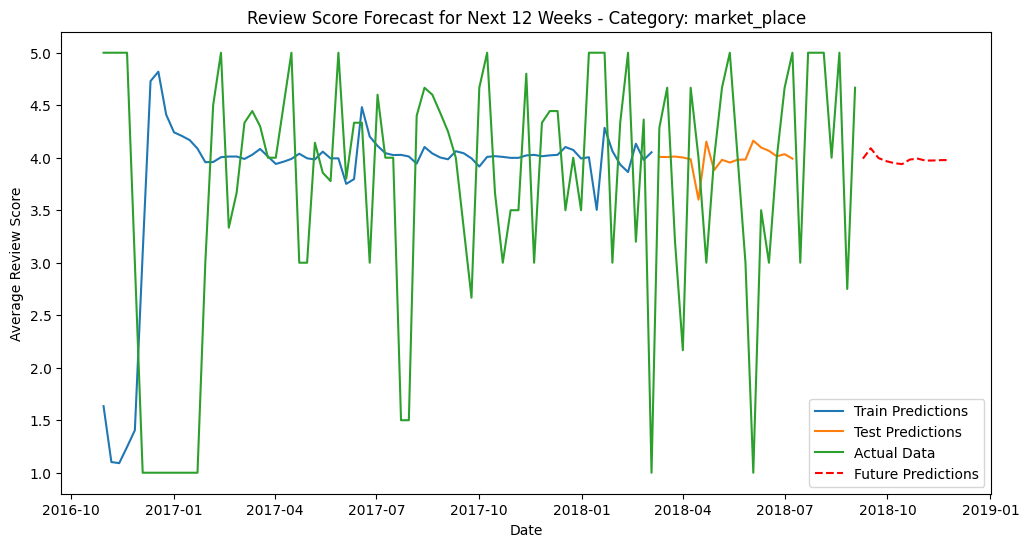

Forecasting for category: bebidas
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4706 - val_loss: 0.0535
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0739 - val_loss: 0.0533
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0715 - val_loss: 0.0348
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0873 - val_loss: 0.0364
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0615 - val_loss: 0.0347
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0905 - val_loss: 0.0337
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0717 - val_loss: 0.0396
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0823 - val_loss: 0.0331
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0604 - val_loss: 0.0329
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0588 - val_loss: 0.0336
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0768 - val_loss: 0.0408
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0625 - val_l

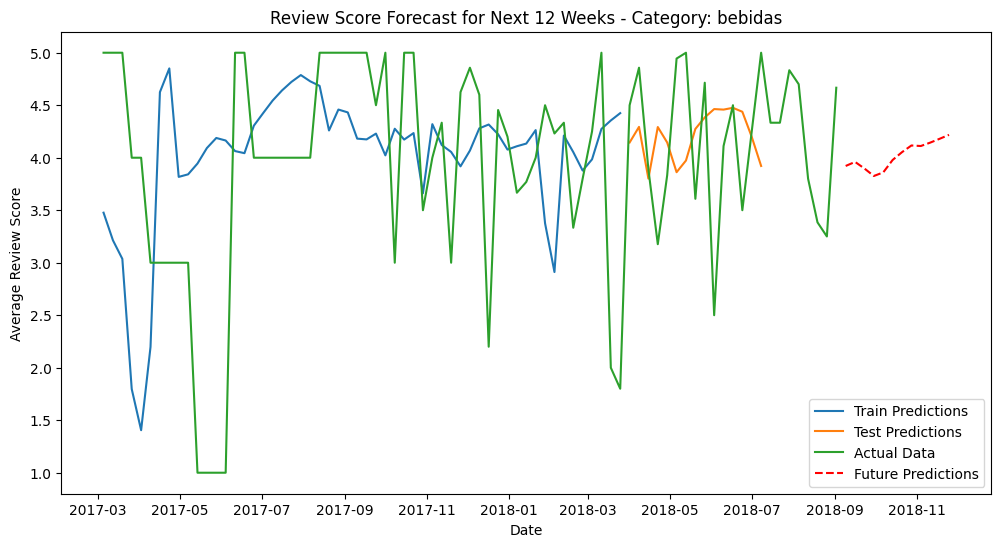

Forecasting for category: moveis_cozinha_area_de_servico_jantar_e_jardim
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3269 - val_loss: 0.0914
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0756 - val_loss: 0.0948
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0679 - val_loss: 0.0868
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0805 - val_loss: 0.0921
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0585 - val_loss: 0.0838
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0854 - val_loss: 0.0871
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0584 - val_loss: 0.0819
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560 - val_loss: 0.0808
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0597 - val_loss: 0.0820
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519 - val_loss: 0.0793
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0452 - val_loss: 0.0785
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0396 - val_l

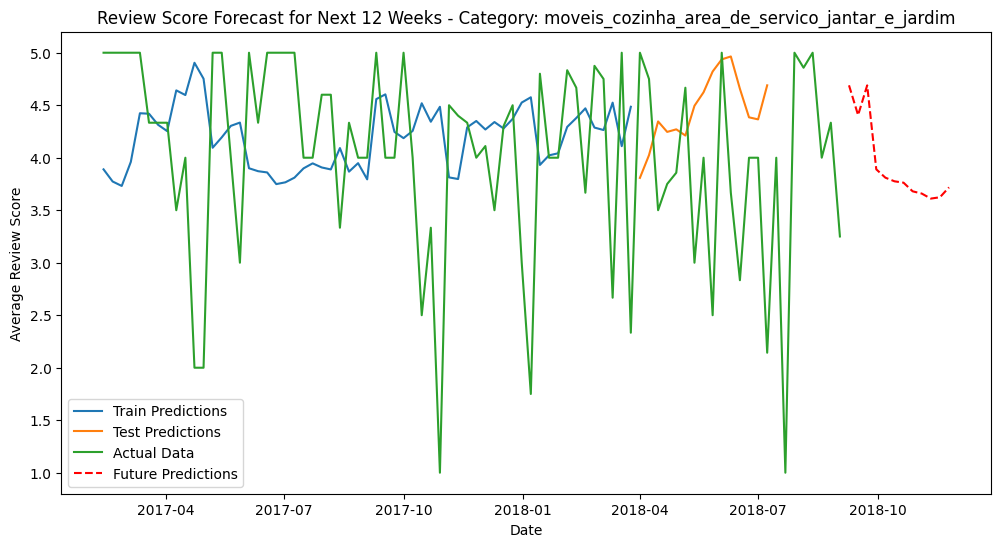

Forecasting for category: musica
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.4795 - val_loss: 0.1439
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1028 - val_loss: 0.1405
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0597 - val_loss: 0.1609
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0723 - val_loss: 0.1611
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0837 - val_loss: 0.1400
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0791 - val_loss: 0.1404
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0614 - val_loss: 0.1341
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0622 - val_loss: 0.1322
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0853 - val_loss: 0.1319
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0537 - val_loss: 0.1328
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0805 - val_loss: 0.1263
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0763 - val_l

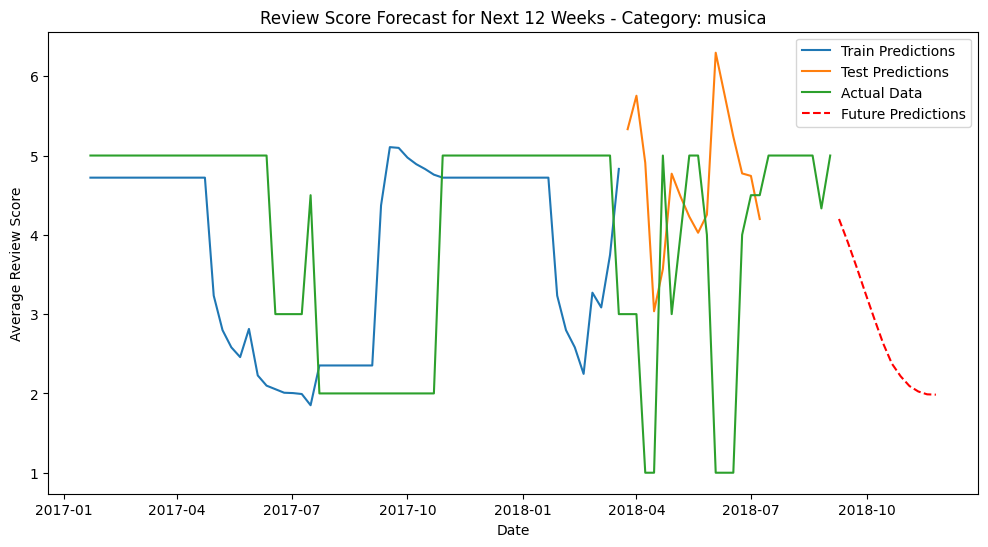

Forecasting for category: moveis_quarto
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.4143 - val_loss: 0.0695
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0874 - val_loss: 0.0684
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0803 - val_loss: 0.0684
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1042 - val_loss: 0.0695
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0987 - val_loss: 0.0664
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0615 - val_loss: 0.0722
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1028 - val_loss: 0.0678
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0609 - val_loss: 0.0662
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1018 - val_loss: 0.0653
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0966 - val_loss: 0.0642
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0627 - val_loss: 0.0693
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0957 - val_l

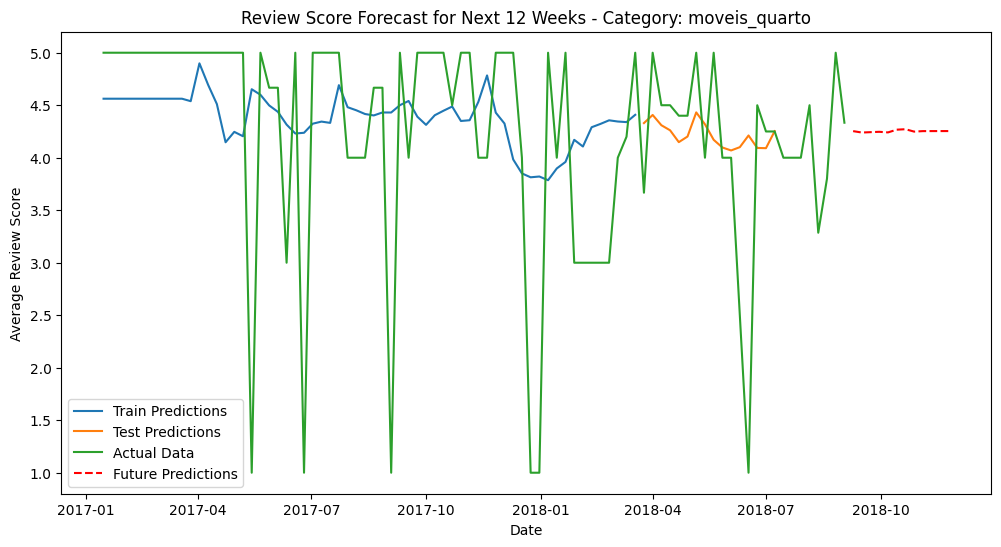

Forecasting for category: la_cuisine
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8760 - val_loss: 0.0947
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0780 - val_loss: 0.0911
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - val_loss: 0.1040
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0258 - val_loss: 0.1025
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.1162
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7217e-04 - val_loss: 0.1174
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6910e-04 - val_loss: 0.1119
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0238e-05 - val_loss: 0.1082
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7878e-05 - val_loss: 0.1101
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8539e-05 - val_loss: 0.1078
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6464e-05 - val_loss: 0.1089
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

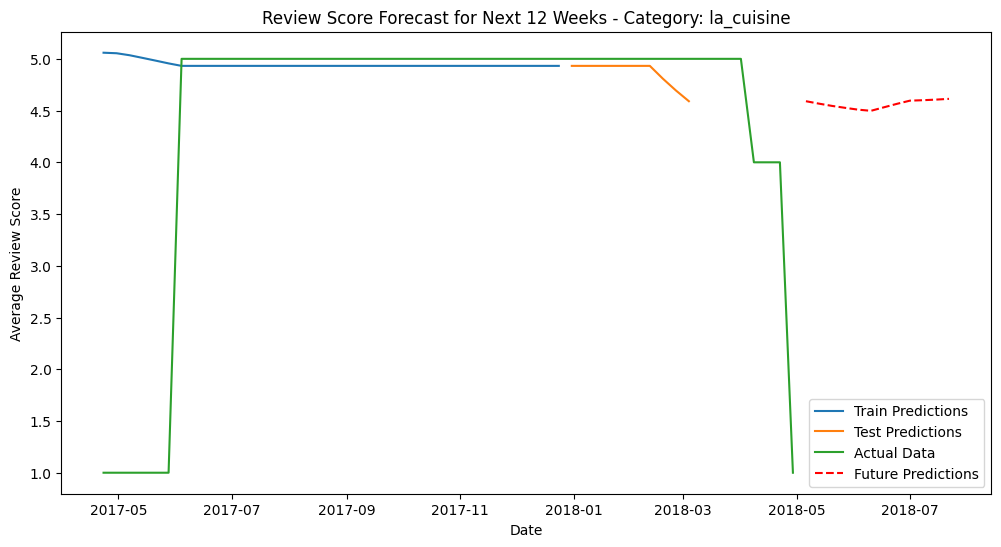

Forecasting for category: sinalizacao_e_seguranca
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.5476 - val_loss: 0.0591
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1300 - val_loss: 0.0470
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0921 - val_loss: 0.0423
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1195 - val_loss: 0.0440
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0847 - val_loss: 0.0573
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1337 - val_loss: 0.0572
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0973 - val_loss: 0.0744
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1109 - val_loss: 0.0595
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0674 - val_loss: 0.1088
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1137 - val_loss: 0.0744
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1005 - val_loss: 0.0833
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1043 - val_l

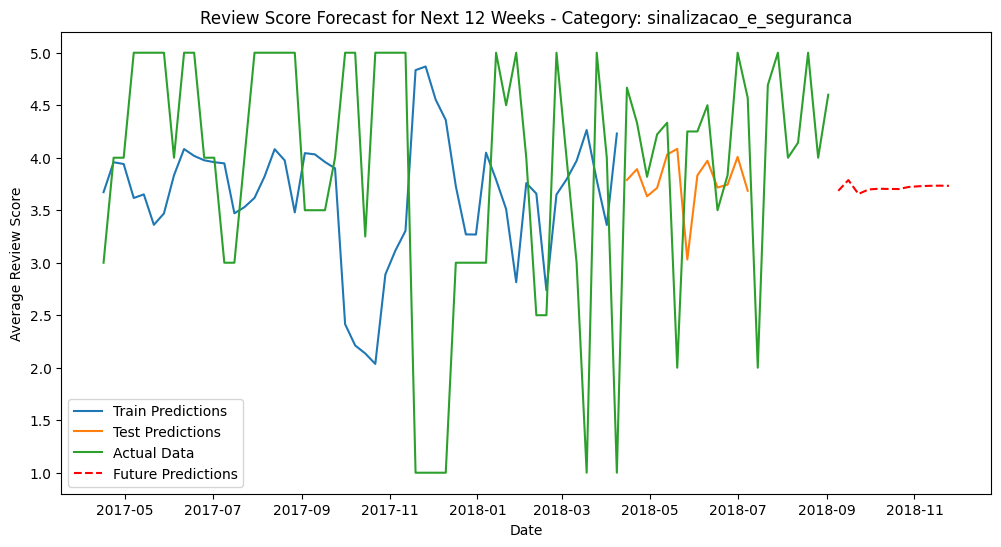

Forecasting for category: casa_construcao
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3862 - val_loss: 0.0203
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0791 - val_loss: 0.0531
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0829 - val_loss: 0.0218
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0730 - val_loss: 0.0194
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0681 - val_loss: 0.0192
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0823 - val_loss: 0.0230
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0759 - val_loss: 0.0189
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0644 - val_loss: 0.0201
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0954 - val_loss: 0.0228
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0468 - val_loss: 0.0256
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0567 - val_loss: 0.0297
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0636 - val_l

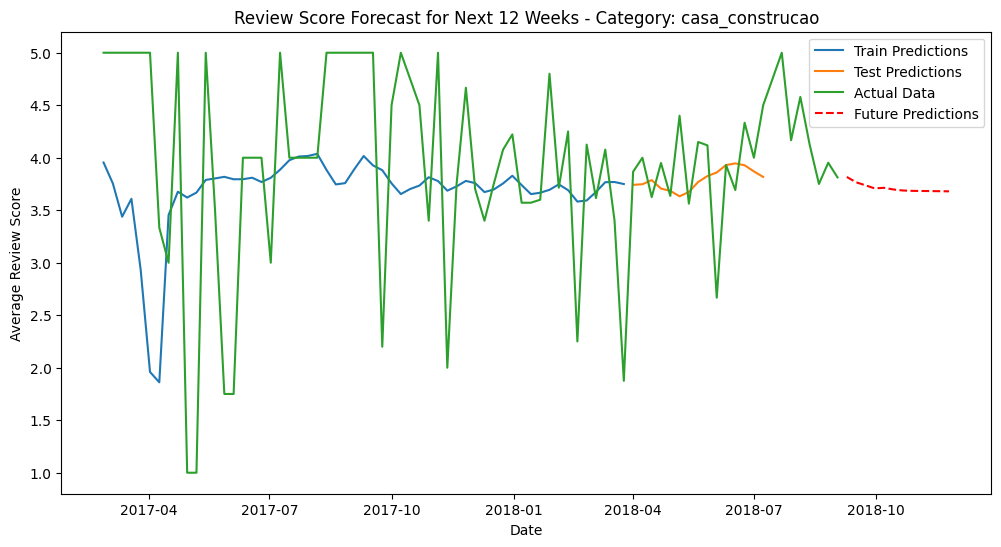

Forecasting for category: alimentos
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.5028 - val_loss: 0.0169
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0502 - val_loss: 0.0184
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0598 - val_loss: 0.0235
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0547 - val_loss: 0.0302
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0663 - val_loss: 0.0146
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0509 - val_loss: 0.0208
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0707 - val_loss: 0.0209
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0604 - val_loss: 0.0194
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0624 - val_loss: 0.0221
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0691 - val_loss: 0.0161
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0455 - val_loss: 0.0197
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0598 - val_l

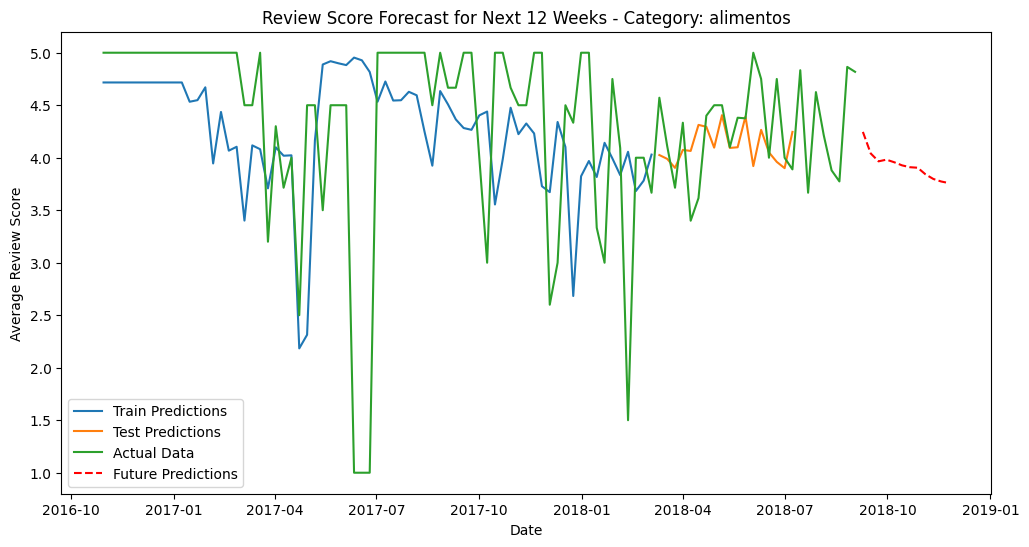

Forecasting for category: portateis_casa_forno_e_cafe
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.4507 - val_loss: 0.1363
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1651 - val_loss: 0.0555
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1577 - val_loss: 0.0207
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1348 - val_loss: 0.0117
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0960 - val_loss: 0.0110
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0810 - val_loss: 0.0255
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0720 - val_loss: 0.0149
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0725 - val_loss: 0.0167
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0585 - val_loss: 0.0414
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1206 - val_loss: 0.0370
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0578 - val_loss: 0.0249
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0583 - val_l

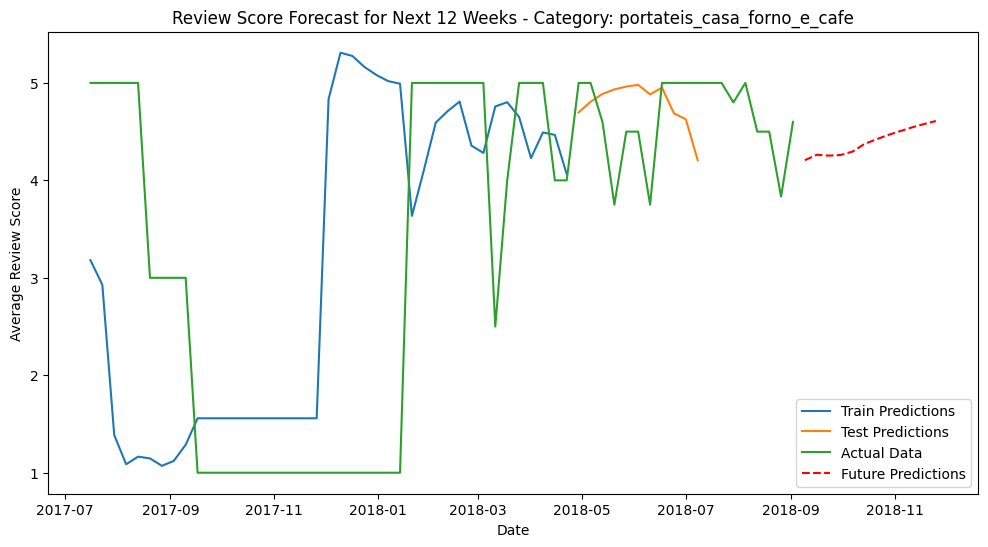

Forecasting for category: climatizacao
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3476 - val_loss: 0.0727
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0876 - val_loss: 0.0922
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1130 - val_loss: 0.0720
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1019 - val_loss: 0.0741
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0818 - val_loss: 0.0755
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1003 - val_loss: 0.0848
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0681 - val_loss: 0.0750
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0720 - val_loss: 0.0755
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0716 - val_loss: 0.0791
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1051 - val_loss: 0.0750
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0977 - val_loss: 0.0768
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0755 - val_l

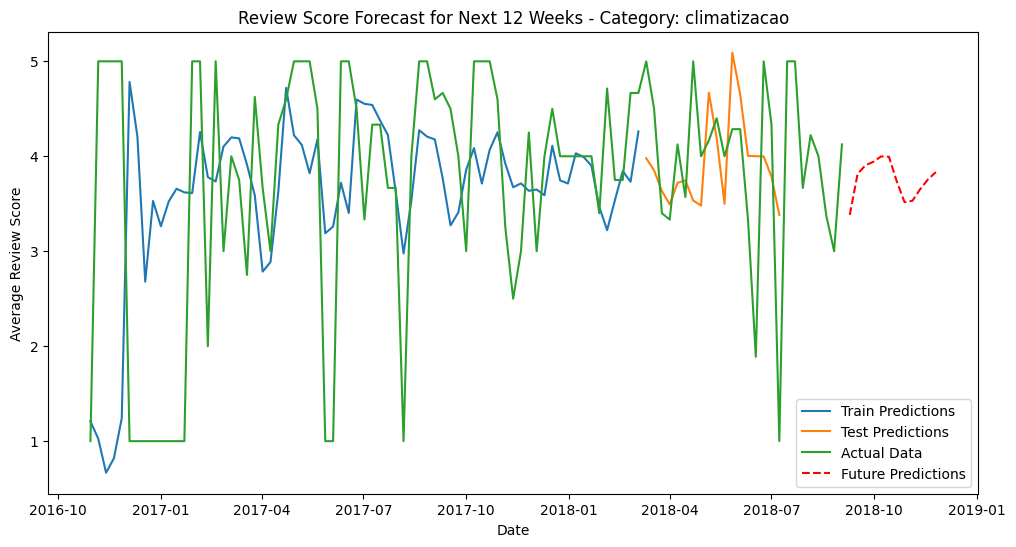

Forecasting for category: cine_foto
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4151 - val_loss: 0.0934
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1230 - val_loss: 0.0928
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1079 - val_loss: 0.0960
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0836 - val_loss: 0.0930
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0704 - val_loss: 0.0952
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0779 - val_loss: 0.0870
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0635 - val_loss: 0.0905
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0542 - val_loss: 0.0869
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0747 - val_loss: 0.0893
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0657 - val_loss: 0.0880
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0618 - val_loss: 0.0888
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0693 - val_l

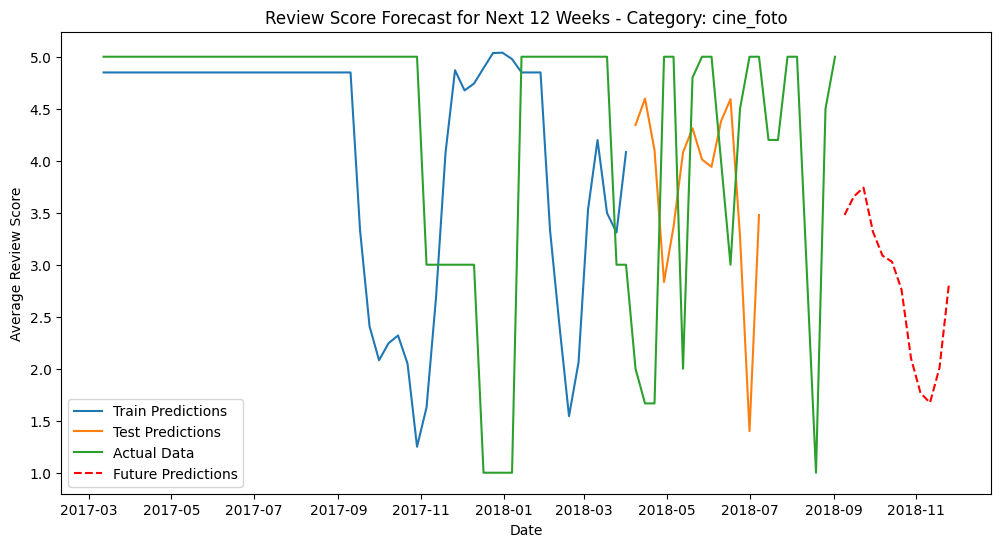

Forecasting for category: fashion_calcados
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3867 - val_loss: 0.0429
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0574 - val_loss: 0.0435
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0417 - val_loss: 0.0524
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0496 - val_loss: 0.0799
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0623 - val_loss: 0.0463
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0470 - val_loss: 0.0422
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0666 - val_loss: 0.0438
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0674 - val_loss: 0.0422
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0646 - val_loss: 0.0416
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0455 - val_loss: 0.0409
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0465 - val_loss: 0.0570
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - val_l

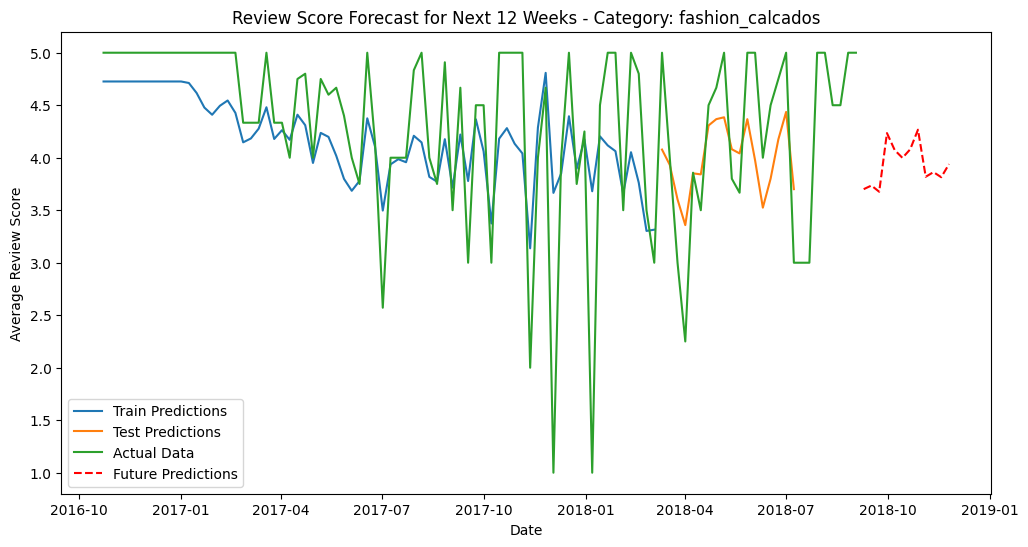

Forecasting for category: agro_industria_e_comercio
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3099 - val_loss: 0.0379
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1176 - val_loss: 0.0447
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0647 - val_loss: 0.0463
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1144 - val_loss: 0.0358
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0785 - val_loss: 0.0358
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1214 - val_loss: 0.0525
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1558 - val_loss: 0.0411
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0944 - val_loss: 0.0371
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0948 - val_loss: 0.0359
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0675 - val_loss: 0.0368
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0681 - val_loss: 0.0382
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0936 - val_l

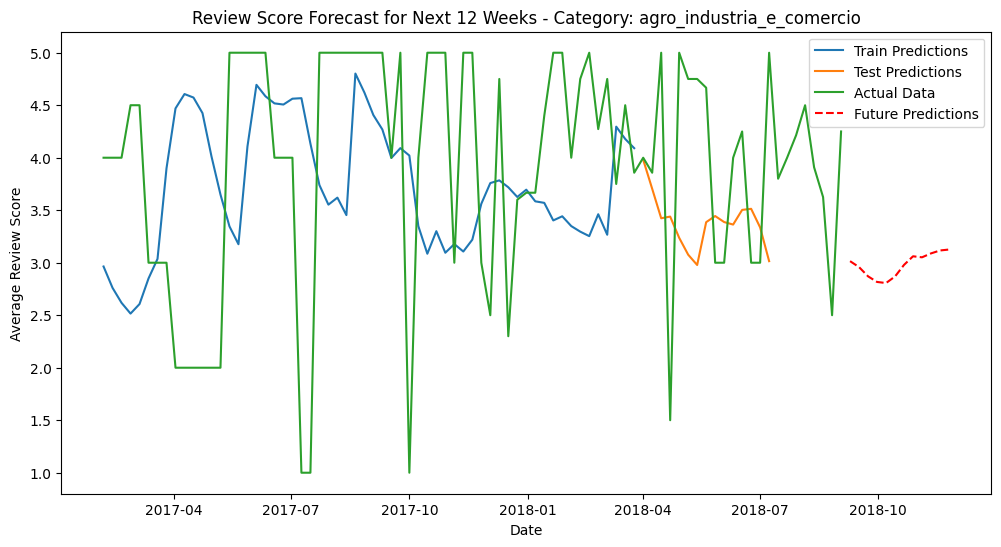

Forecasting for category: moveis_colchao_e_estofado
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.4999 - val_loss: 0.1098
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0932 - val_loss: 0.1206
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0933 - val_loss: 0.1075
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1011 - val_loss: 0.1412
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0834 - val_loss: 0.1204
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1240 - val_loss: 0.1427
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0954 - val_loss: 0.1434
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0979 - val_loss: 0.1614
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1245 - val_loss: 0.2260
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1397 - val_loss: 0.1799
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0843 - val_loss: 0.1884
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0829 - val_l

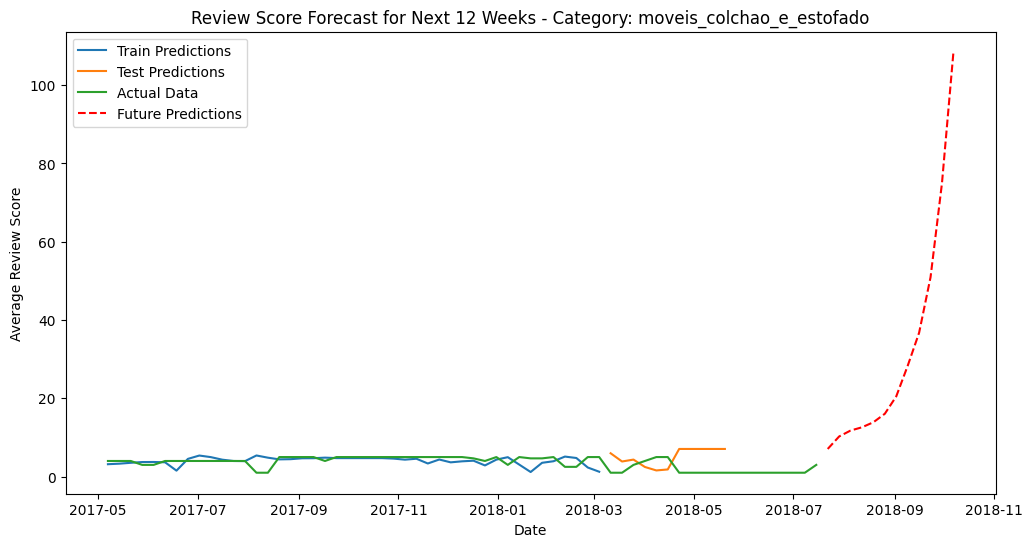

Forecasting for category: casa_conforto_2
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.5552 - val_loss: 0.0605
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0873 - val_loss: 0.0563
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0556 - val_loss: 0.0540
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0733 - val_loss: 0.0484
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0587 - val_loss: 0.0465
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0589 - val_loss: 0.0447
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0770 - val_loss: 0.0420
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0478 - val_loss: 0.0420
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0513 - val_loss: 0.0399
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0493 - val_loss: 0.0403
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0566 - val_loss: 0.0382
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0471 - val_l

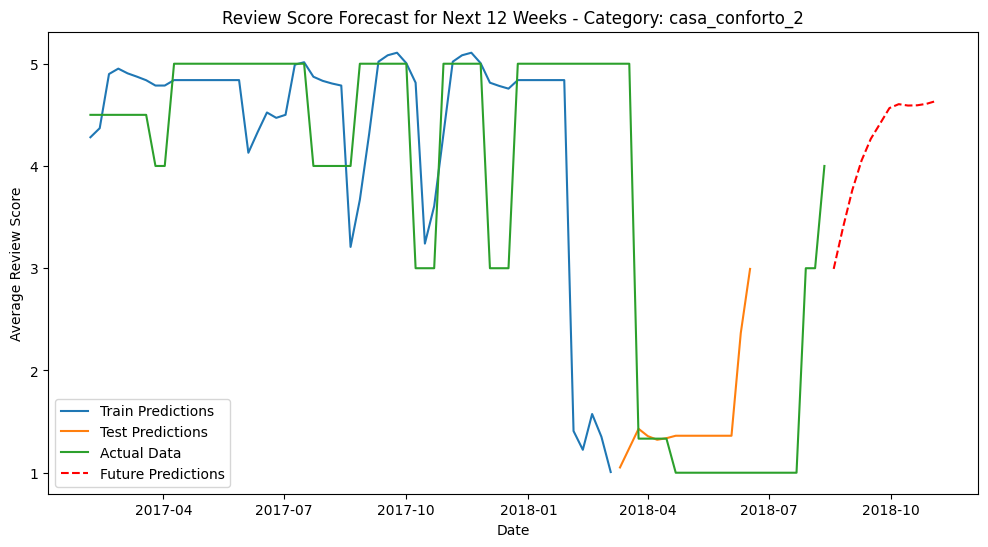

Forecasting for category: fashion_underwear_e_moda_praia
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3460 - val_loss: 0.1056
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0575 - val_loss: 0.1361
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0822 - val_loss: 0.1048
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0522 - val_loss: 0.1060
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0509 - val_loss: 0.1018
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0338 - val_loss: 0.1017
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0329 - val_loss: 0.1020
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0369 - val_loss: 0.1002
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0534 - val_loss: 0.1009
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0478 - val_loss: 0.0991
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0508 - val_loss: 0.0985
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0542 - val_l

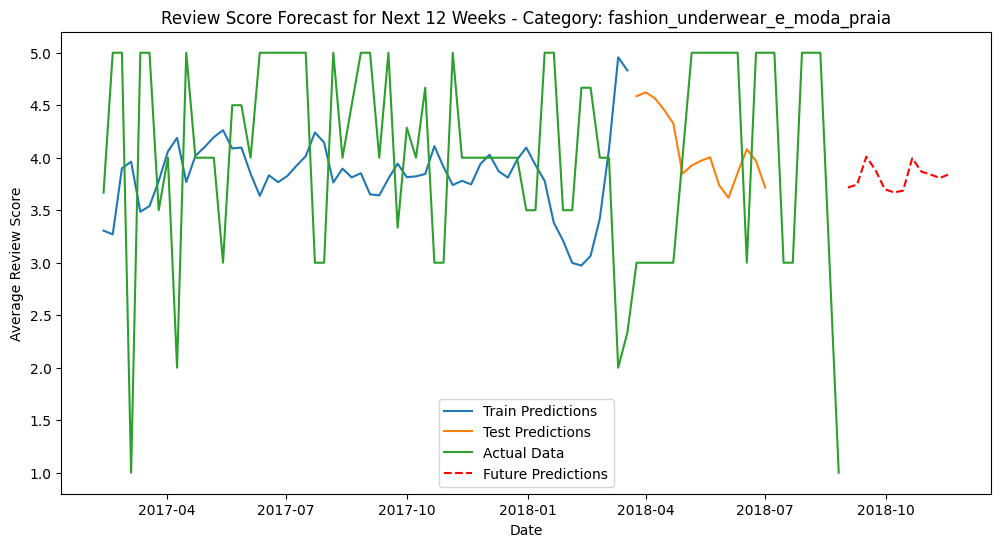

Forecasting for category: construcao_ferramentas_iluminacao
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.3509 - val_loss: 0.0262
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1370 - val_loss: 0.0252
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0922 - val_loss: 0.0248
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1127 - val_loss: 0.0245
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1257 - val_loss: 0.0222
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1012 - val_loss: 0.0277
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0741 - val_loss: 0.0245
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0898 - val_loss: 0.0234
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0912 - val_loss: 0.0217
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0712 - val_loss: 0.0262
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0624 - val_loss: 0.0186
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1181 - val_l

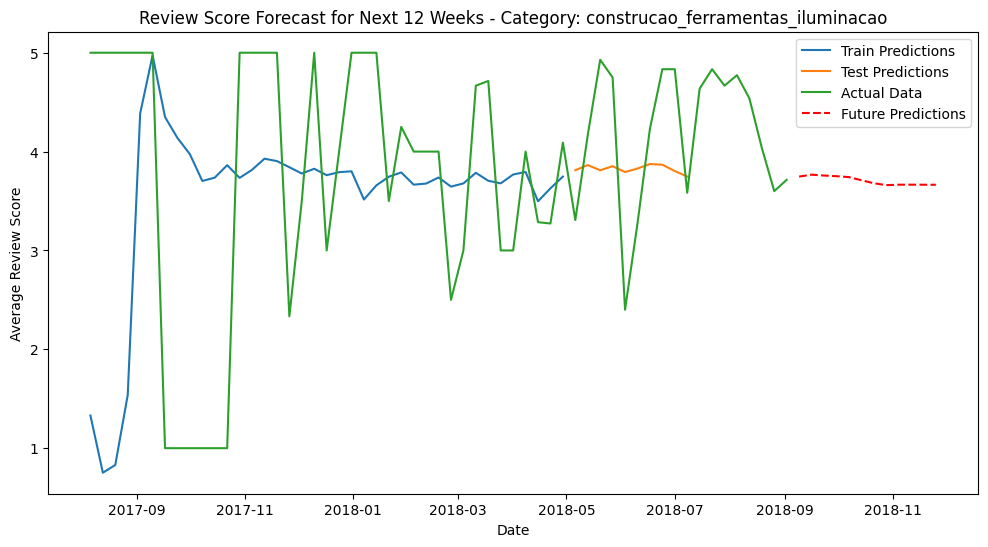

Forecasting for category: dvds_blu_ray
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.5858 - val_loss: 0.1537
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0693 - val_loss: 0.1491
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0663 - val_loss: 0.1407
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0811 - val_loss: 0.1374
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0646 - val_loss: 0.1510
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0769 - val_loss: 0.1491
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0684 - val_loss: 0.1455
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0896 - val_loss: 0.1952
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0703 - val_loss: 0.1333
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0657 - val_loss: 0.1477
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0773 - val_loss: 0.1327
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0956 - val_l

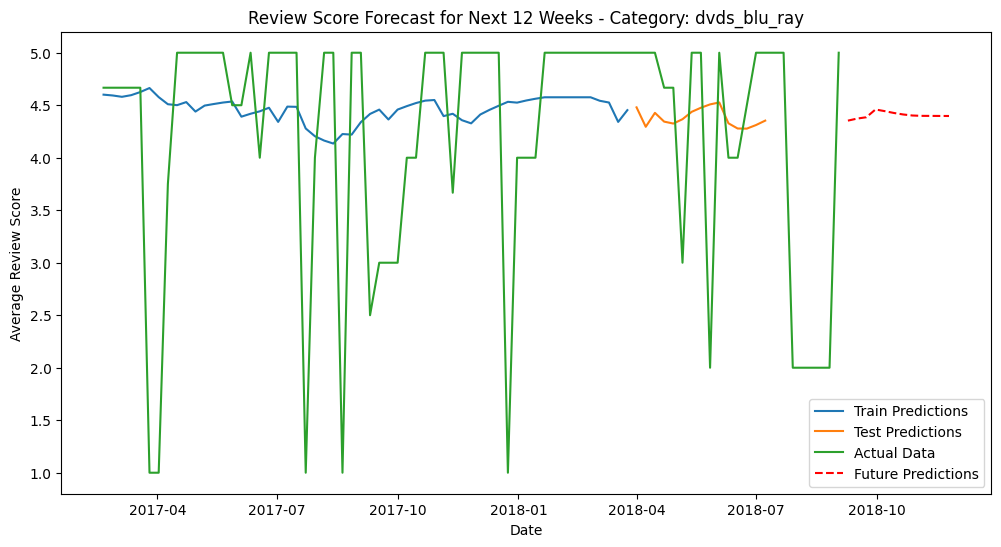

Forecasting for category: construcao_ferramentas_ferramentas
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6020 - val_loss: 0.0623
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0632 - val_loss: 0.0182
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0495 - val_loss: 0.0172
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0418 - val_loss: 0.0202
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0373 - val_loss: 0.0171
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0382 - val_loss: 0.0362
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0549 - val_loss: 0.0165
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0583 - val_loss: 0.0232
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0597 - val_loss: 0.0186
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0350 - val_loss: 0.0195
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444 - val_loss: 0.0163
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422 - val_l

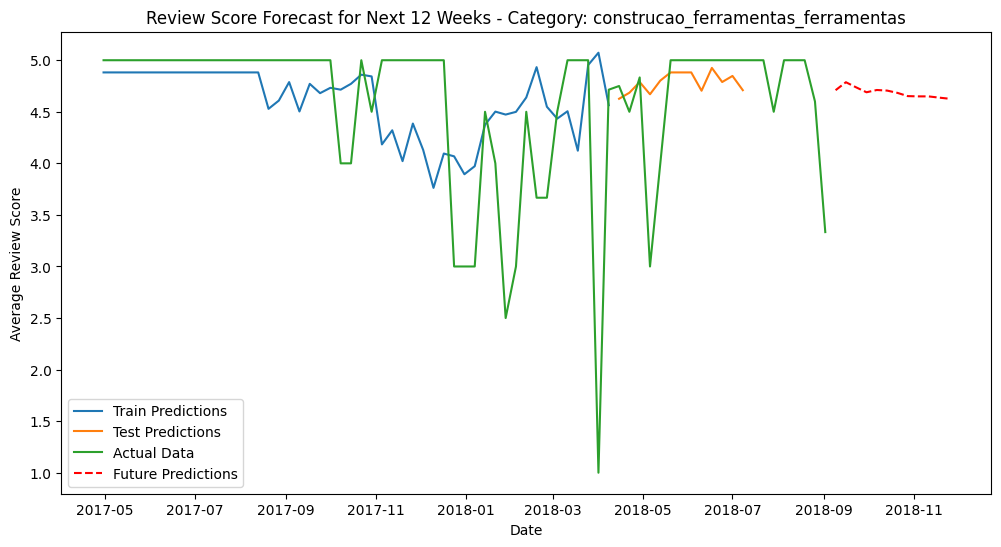

Forecasting for category: fashion_roupa_masculina
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1751 - val_loss: 0.0267
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0840 - val_loss: 0.0119
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0983 - val_loss: 0.0062
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1115 - val_loss: 0.0077
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0996 - val_loss: 0.0077
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1219 - val_loss: 0.0348
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1042 - val_loss: 0.0114
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0852 - val_loss: 0.0102
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1312 - val_loss: 0.0080
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1195 - val_loss: 0.0108
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1240 - val_loss: 0.0116
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0968 - val_l

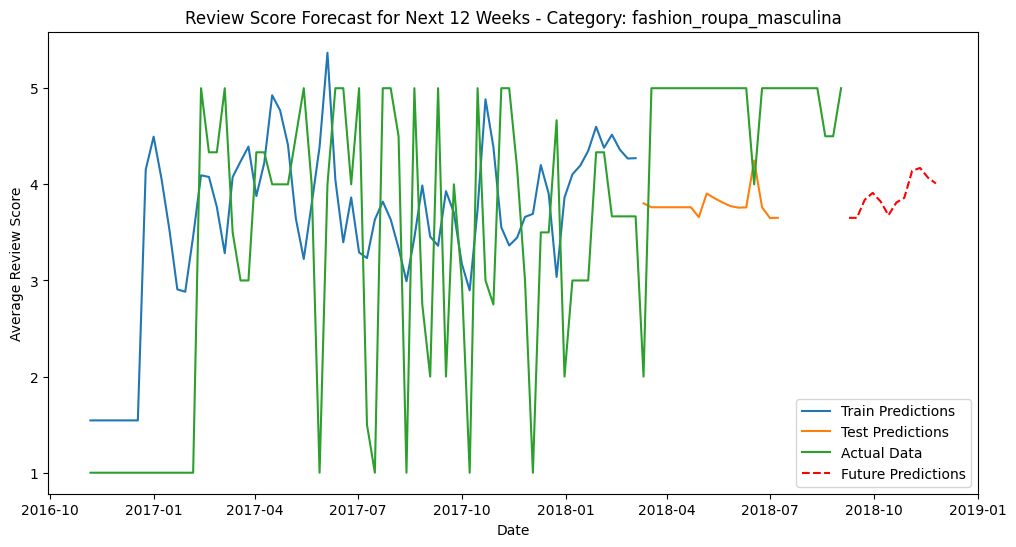

Forecasting for category: telefonia_fixa
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3883 - val_loss: 0.0866
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0767 - val_loss: 0.0939
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0482 - val_loss: 0.0884
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0593 - val_loss: 0.0855
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0643 - val_loss: 0.0847
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0538 - val_loss: 0.0966
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0800 - val_loss: 0.0844
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0564 - val_loss: 0.0898
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0590 - val_loss: 0.0900
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0951 - val_loss: 0.0852
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0768 - val_loss: 0.0890
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0529 - val_l

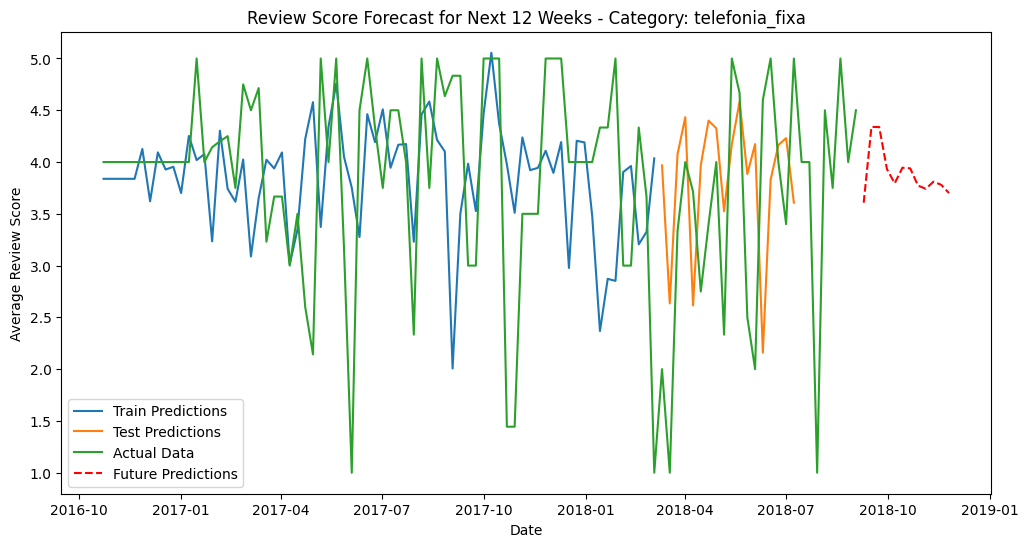

Forecasting for category: construcao_ferramentas_jardim
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4386 - val_loss: 0.0463
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0799 - val_loss: 0.0426
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0775 - val_loss: 0.0611
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1234 - val_loss: 0.0414
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1011 - val_loss: 0.0450
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0910 - val_loss: 0.0520
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0932 - val_loss: 0.0418
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0665 - val_loss: 0.0438
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399 - val_loss: 0.0472
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0694 - val_loss: 0.0420
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0681 - val_loss: 0.0406
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0624 - val_l

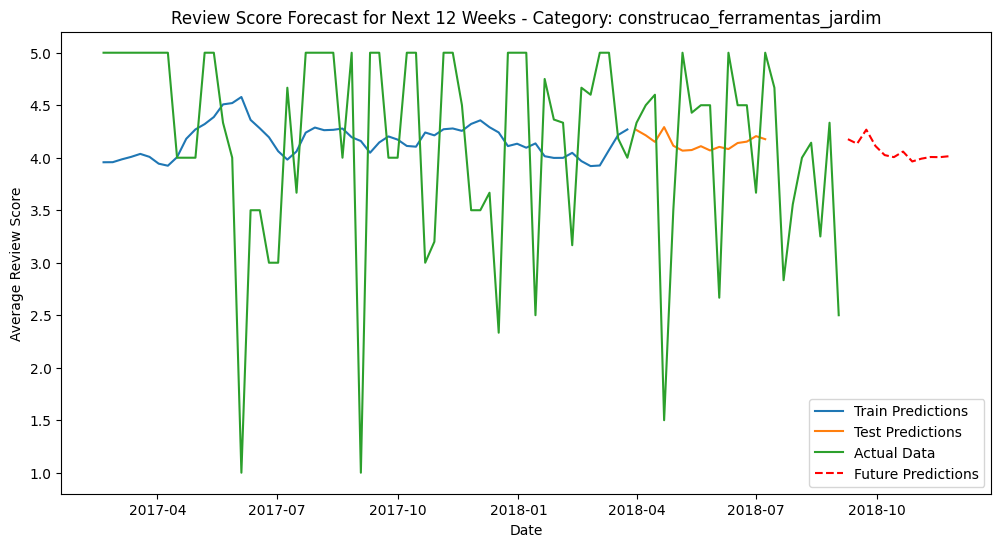

Forecasting for category: fashion_roupa_feminina
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3564 - val_loss: 0.0101
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0647 - val_loss: 0.0068
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0958 - val_loss: 8.7171e-04
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0818 - val_loss: 0.0178
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0851 - val_loss: 0.0012
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0587 - val_loss: 9.4853e-04
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0811 - val_loss: 0.0022
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0651 - val_loss: 0.0013
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0785 - val_loss: 0.0271
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0649 - val_loss: 0.0023
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0639 - val_loss: 0.0023
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0861

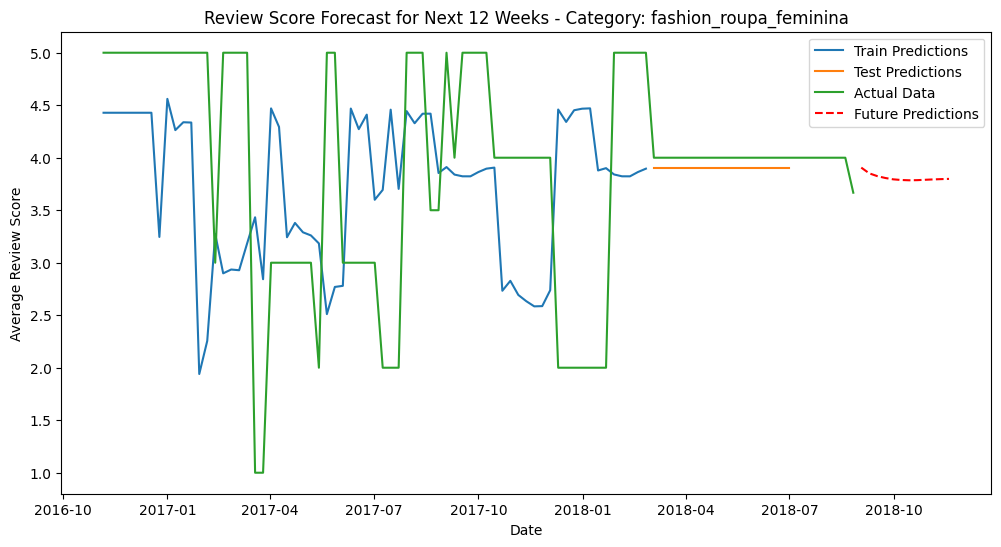

Forecasting for category: fashion_esporte
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6221 - val_loss: 0.0169
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0680 - val_loss: 0.0280
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0842 - val_loss: 0.0216
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0521 - val_loss: 0.0188
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0654 - val_loss: 0.0166
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0587 - val_loss: 0.0175
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0858 - val_loss: 0.0314
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0502 - val_loss: 0.0173
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0555 - val_loss: 0.0249
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410 - val_loss: 0.0235
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0351 - val_loss: 0.0329
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0528 - val_l

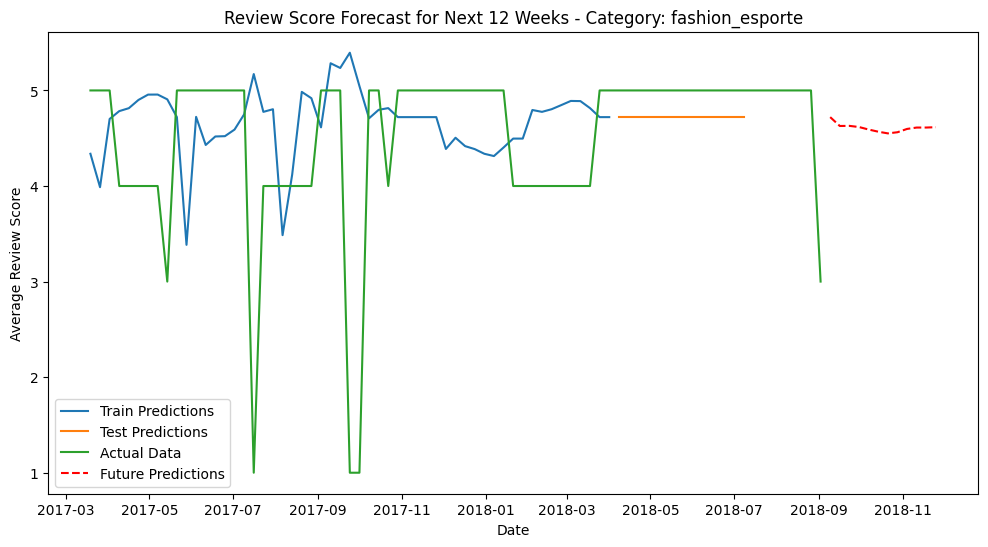

Forecasting for category: portateis_cozinha_e_preparadores_de_alimentos
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.4527 - val_loss: 0.2951
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5245 - val_loss: 0.2409
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2435 - val_loss: 0.1941
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1576 - val_loss: 0.1435
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1687 - val_loss: 0.0964
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1118 - val_loss: 0.0530
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1942 - val_loss: 0.0278
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1486 - val_loss: 0.0146
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1999 - val_loss: 0.0173
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1305 - val_loss: 0.0200
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1159 - val_loss: 0.0285
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0846 - val_loss: 0.0252


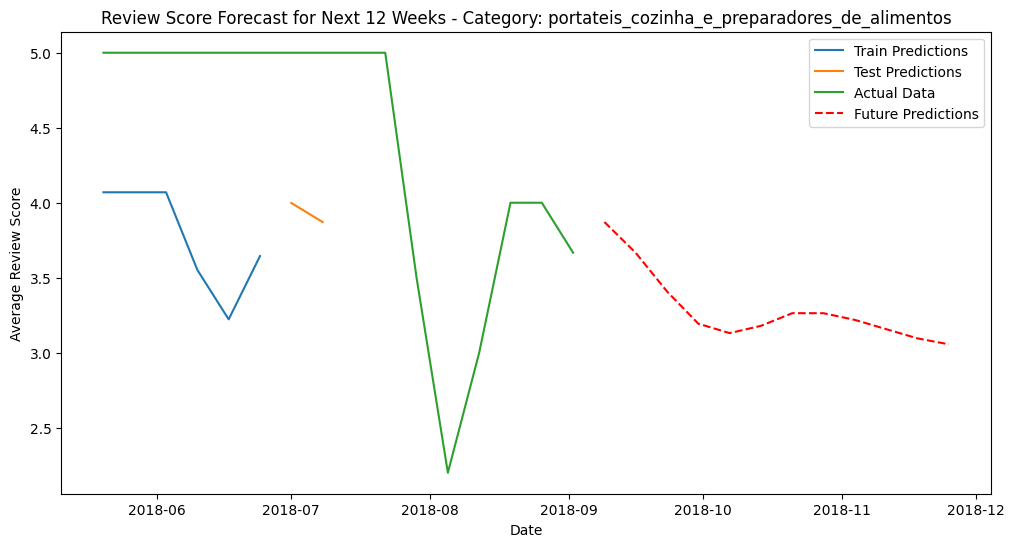

Forecasting for category: tablets_impressao_imagem
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.6579 - val_loss: 0.0493
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0925 - val_loss: 0.0569
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0628 - val_loss: 0.1053
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0969 - val_loss: 0.1002
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0885 - val_loss: 0.1008
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0935 - val_loss: 0.0295
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0719 - val_loss: 0.0592
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1252 - val_loss: 0.0291
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0523 - val_loss: 0.0780
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0659 - val_loss: 0.0630
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0762 - val_loss: 0.0238
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560 - val_l

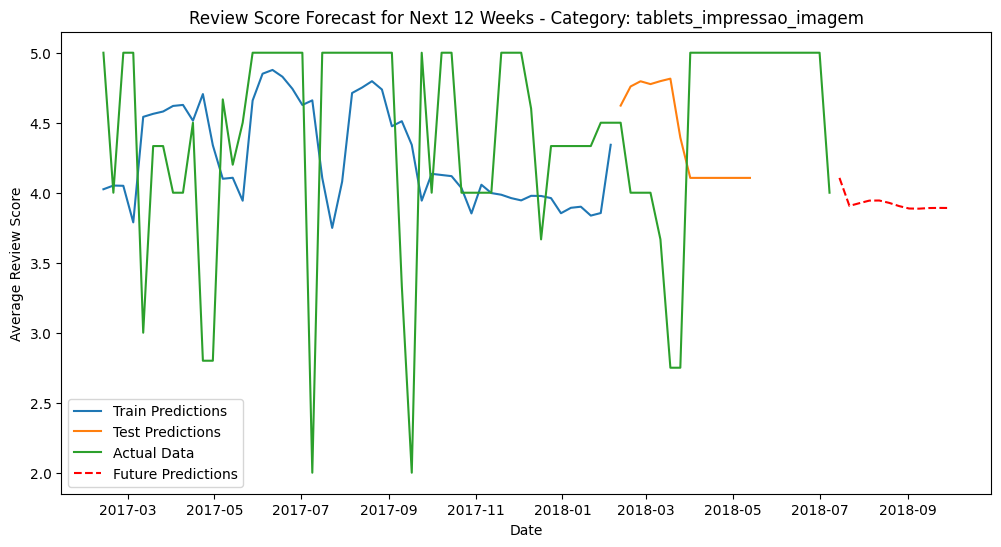

Forecasting for category: cds_dvds_musicais


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.9428 - val_loss: 0.3602
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2153 - val_loss: 0.0279
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_loss: 0.0016
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 5.3489e-06
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 4.6420e-06
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 1.8503e-05
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 1.7346e-05
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4174e-04 - val_loss: 1.3939e-04
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3818e-04 - val_loss: 5.7302e-07
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 2.2364e-07
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4395e-04 - val_loss: 1.3684e-05
Epoch 12/100
28/28

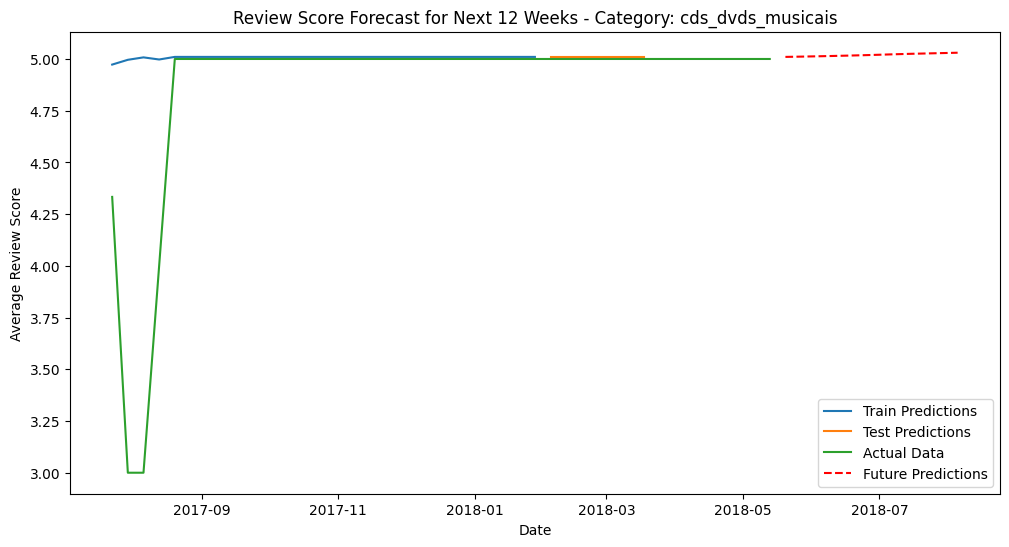

Forecasting for category: flores
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.4244 - val_loss: 0.4152
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2023 - val_loss: 0.0851
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1023 - val_loss: 0.0847
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0912 - val_loss: 0.0795
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1128 - val_loss: 0.0830
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0682 - val_loss: 0.1057
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1109 - val_loss: 0.1053
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0731 - val_loss: 0.0858
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1619 - val_loss: 0.0772
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0654 - val_loss: 0.0835
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0674 - val_loss: 0.0860
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1634 - val_l

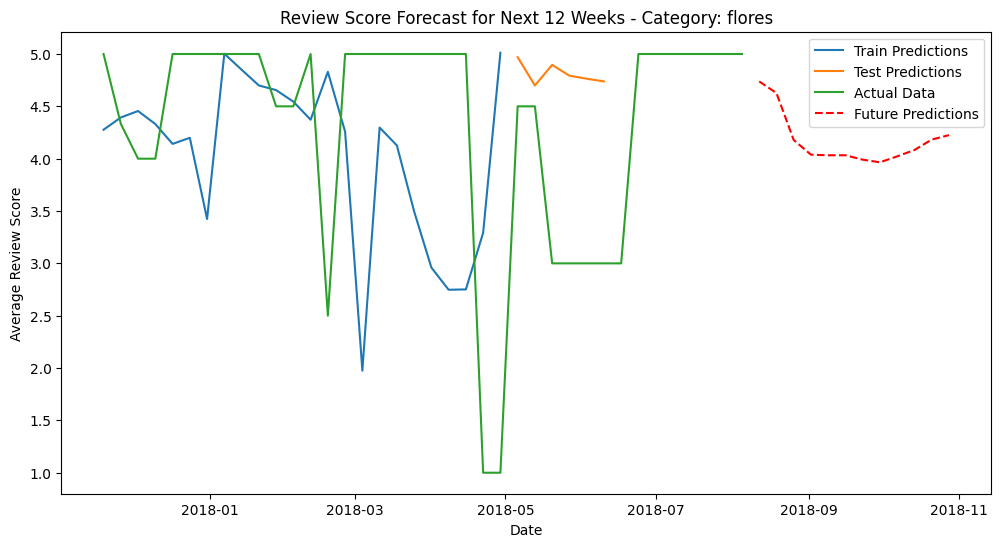

Forecasting for category: fraldas_higiene
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5582 - val_loss: 0.0815
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0314 - val_loss: 0.1015
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0722 - val_loss: 0.0819
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0869 - val_loss: 0.0769
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0359 - val_loss: 0.0821
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0517 - val_loss: 0.0739
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151 - val_loss: 0.0958
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0385 - val_loss: 0.0938
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0398 - val_loss: 0.0721
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0246 - val_loss: 0.0707
Epoch 11/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0207 - val_loss: 0.0743
Epoch 12/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_l

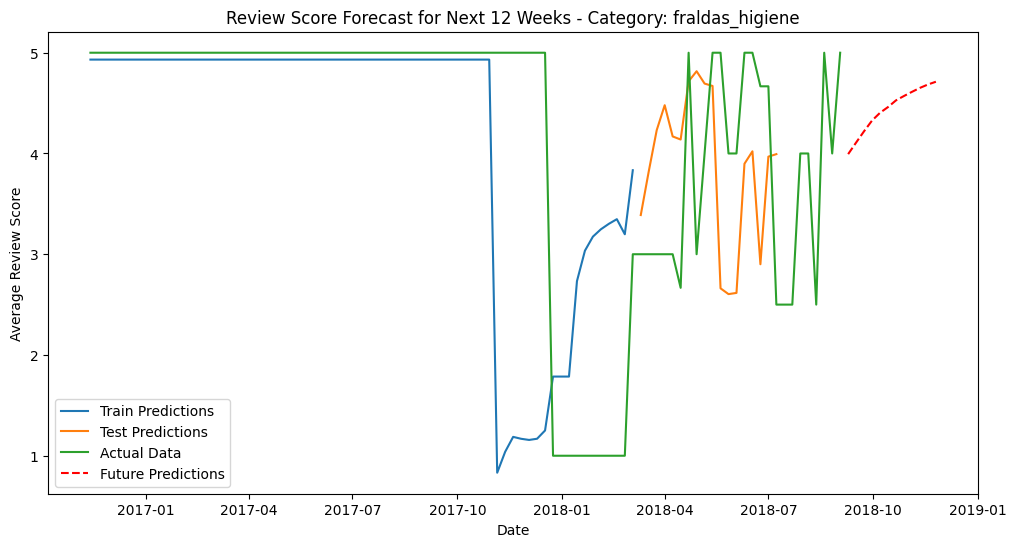

Forecasting for category: pc_gamer
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2232 - val_loss: 0.0767
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0340 - val_loss: 0.0895
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - val_loss: 0.1370
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0263 - val_loss: 0.1322
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0316 - val_loss: 0.1218
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.1319
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.1331
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 - val_loss: 0.1133
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.1170
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.1089
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330 - val_loss: 0.1141
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_l

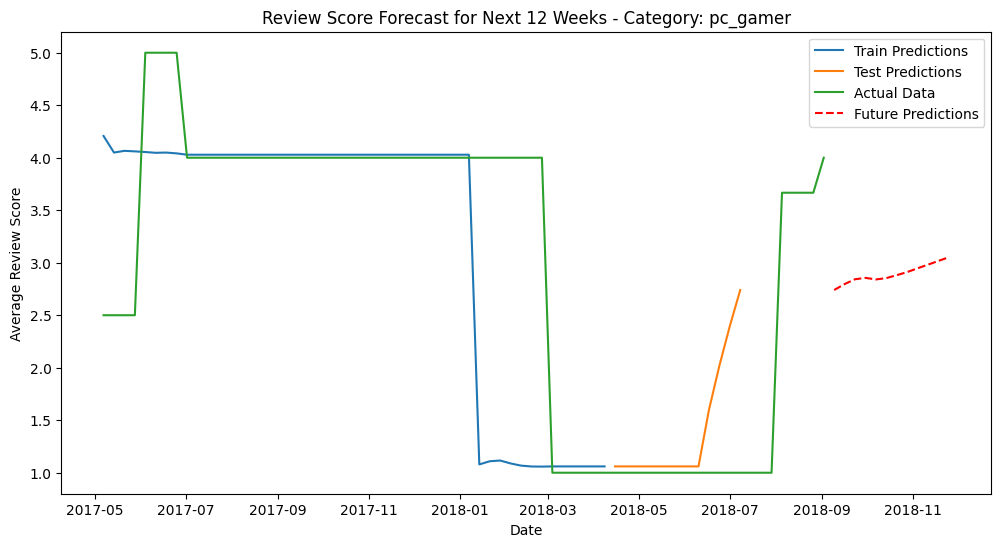

Forecasting for category: artigos_de_festas
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.3670 - val_loss: 0.0790
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1711 - val_loss: 0.0708
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1489 - val_loss: 0.0882
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1545 - val_loss: 0.0498
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1485 - val_loss: 0.0679
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1473 - val_loss: 0.0322
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1417 - val_loss: 0.0690
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1703 - val_loss: 0.0536
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1655 - val_loss: 0.0785
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1083 - val_loss: 0.0573
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0933 - val_loss: 0.0895
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1778 - val_l

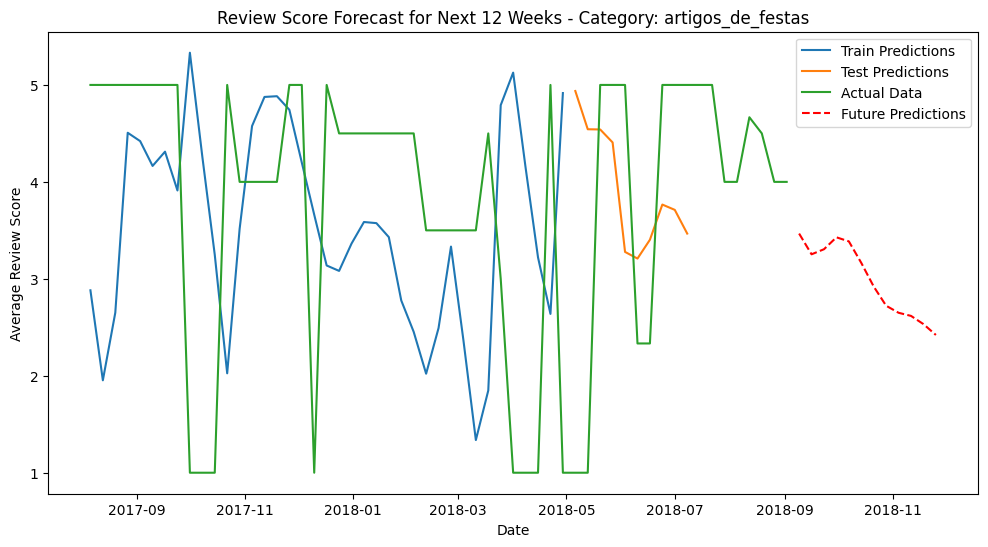

Forecasting for category: fashion_roupa_infanto_juvenil
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6191 - val_loss: 9.0983e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1613 - val_loss: 0.0296
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0963 - val_loss: 0.0185
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1004 - val_loss: 0.0089
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0995 - val_loss: 0.0073
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0873 - val_loss: 0.0027
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1151 - val_loss: 0.0041
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1070 - val_loss: 0.0013
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0915 - val_loss: 0.0101
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0939 - val_loss: 8.6321e-04
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0328 - val_loss: 0.0037
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0422

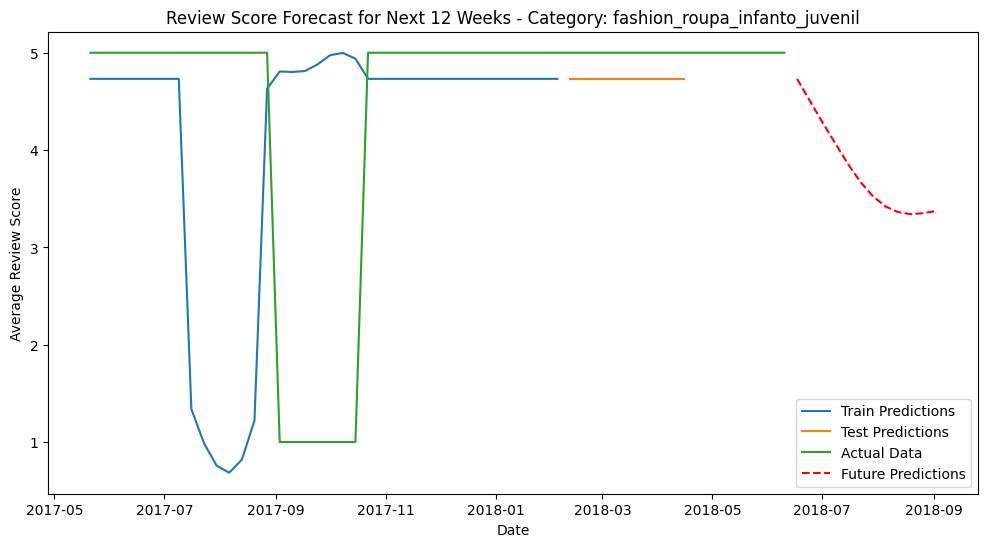

Forecasting for category: artes_e_artesanato
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.6059 - val_loss: 0.0957
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172 - val_loss: 0.0996
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - val_loss: 0.1047
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0998
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.1062
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221 - val_loss: 0.1020
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.1059
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.1051
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 - val_loss: 0.1068
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.1068
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.1133
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161 - val_l

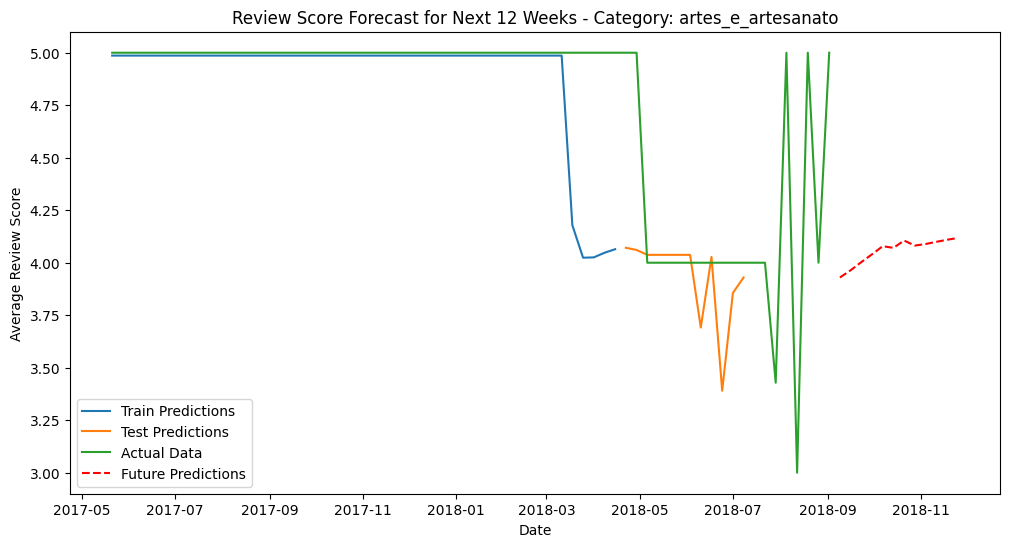

Forecasting for category: seguros_e_servicos
Epoch 1/100


<ipython-input-4-27e60420062e>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.9950 - val_loss: 0.5830
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6364 - val_loss: 0.3232
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2693 - val_loss: 0.1655
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.2033
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.2013
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6718e-04 - val_loss: 0.1982
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3857e-05 - val_loss: 0.2011
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9532e-06 - val_loss: 0.1995
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4913e-07 - val_loss: 0.2001
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7840e-08 - val_loss: 0.2000
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5533e-09 - val_loss: 0.2000
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

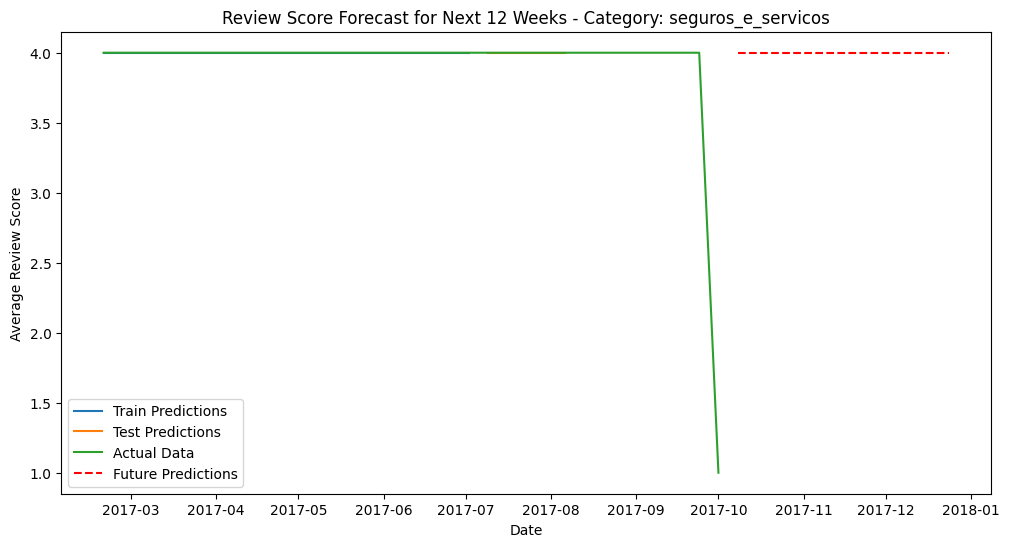

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 1: Read CSV files
order_items = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_order_items_dataset.csv')
order_reviews = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_order_reviews_dataset.csv')
products = pd.read_csv('/content/drive/MyDrive/Phân tích thống kê/Project/olist_dataset/olist_products_dataset.csv')

order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date'])

# Step 2: Merge data
# Merge order_reviews with order_items based on order_id
merged_data = pd.merge(order_reviews, order_items, on='order_id', how='inner')

# Merge merged_data with products based on product_id to add category information
merged_data = pd.merge(merged_data, products, on='product_id', how='inner')

# Iterate through each category to forecast
categories = merged_data['product_category_name'].unique()

for category in categories:
    print(f"Forecasting for category: {category}")

    # Filter data by category
    category_data = merged_data[merged_data['product_category_name'] == category]
    category_data.set_index('review_creation_date', inplace=True)

    # Calculate weekly average review scores for the category
    weekly_avg_score = category_data['review_score'].resample('W').mean()

    # Handle missing values
    weekly_avg_score = weekly_avg_score.fillna(method='ffill')  # Fill missing values using forward-fill

    # Check if the data is too short for training
    if len(weekly_avg_score) < 10:
        print(f"Category '{category}' does not have enough data for forecasting.")
        continue

    # Preprocess data for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(weekly_avg_score.values.reshape(-1, 1))

    # Create sequences for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    seq_length = 8  # Use the past 8 weeks to predict the next week
    X, y = create_sequences(scaled_data, seq_length)

    # Split the dataset into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), verbose=1)

    # Forecast for the next 12 weeks
    predictions = []
    last_sequence = X_test[-1]

    for i in range(12):  # Forecast for the next 12 weeks (3 months)
        next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
        predictions.append(next_pred[0, 0])
        last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

    # Inverse transform the forecasted results
    predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    print("Forecasted review scores for the next 12 weeks:", predicted_values.flatten())

    # Visualize the results
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Inverse transform predictions and actual values
    train_predictions_true = scaler.inverse_transform(train_predictions)
    test_predictions_true = scaler.inverse_transform(test_predictions)
    y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Generate index for future predictions
    future_weeks = pd.date_range(start=weekly_avg_score.index[-1], periods=13, freq='W')[1:]

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_avg_score.index[:len(train_predictions)], train_predictions_true, label="Train Predictions")
    plt.plot(weekly_avg_score.index[len(train_predictions):len(train_predictions) + len(test_predictions)], test_predictions_true, label="Test Predictions")
    plt.plot(weekly_avg_score.index, weekly_avg_score.values, label="Actual Data")
    plt.plot(future_weeks, predicted_values, label="Future Predictions", linestyle='--', color='red')
    plt.title(f"Review Score Forecast for Next 12 Weeks - Category: {category}")
    plt.xlabel("Date")
    plt.ylabel("Average Review Score")
    plt.legend()
    plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate errors on the test dataset
mae = mean_absolute_error(y_test_true, test_predictions_true)
rmse = np.sqrt(mean_squared_error(y_test_true, test_predictions_true))

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.6000004768371582
Root Mean Squared Error (RMSE): 1.3416409997480017
